# 간단한 컨브넷 밑바닥 부터 훈련시키기 

In [10]:
# 네트워크 구성 

from keras import layers 
from keras import models 

model = models.Sequential() 
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3))) # 입력 특성 맵에 적용 할 필터 수: 32, 윈도우 사이즈, 활성화함수, 입력 데이터 규격: 150*150, RGB 3 채널 
model.add(layers.MaxPooling2D((2,2))) # 최대 풀링 연산 적용할 윈도우 사이즈 - 다운샘플링(크기 축소)
model.add(layers.Conv2D(64, (3,3), activation='relu')) # 입력 특성 맵에 적용할 필터 수:64, 윈도우 사이즈, 활성화 함수 
model.add(layers.MaxPooling2D((2,2))) # 윈도우 사이즈 
model.add(layers.Conv2D(128, (3,3), activation='relu')) # 필터 수: 128개, 윈도우 사이즈 
model.add(layers.MaxPooling2D((2,2))) # 윈도우 사이즈 
model.add(layers.Conv2D(128, (3,3), activation='relu')) # 필터 수: 128개, 윈도우 사이즈 
model.add(layers.MaxPooling2D(2,2)) # 윈도우 사이즈 
# 여기까지 합성곱 기반 층(지역 패턴 추출 층)

# 여기서부터 완전 연결 층(전역 패턴 추출, 분류기)
model.add(layers.Flatten()) # 1차원 텐서(벡터)로 변환
model.add(layers.Dense(512, activation='relu')) # 512차원 벡터공간에 투영 
model.add(layers.Dense(1, activation='sigmoid'))

In [3]:
model.summary()
# 1. 150*150 입력 이미지에서 3*3 윈도우 슬라이딩하면서 3*3 패치 추출 -> 32개 필터에 대해 합성곱 -> 148*148*32 
# 2. 2*2 윈도우 1의 출력 특성 맵에 적용해서 패치 구역 별 최댓값만 추출 -> 출력 특성 맵 크기 절반으로 줄어든다 -> 74*74*32 
# 3. 2의 출력 특성 맵에서 다시 3*3 패치 추출 -> 64개 필터에 대해 합성곱 -> 72*72*64 
# 4. 2 처럼 최대 풀링 연산 3 출력에 적용 -> 출력 특성 맵 크기 절반으로 줄어든다 -> 36*36*64 
# 5. 3*3 패치, 128개 필터에 대해 합성곱 -> 34*34*128 
# 6. 최대 풀링 연산 적용 -> 17*17*128 
# 7. 3*3 패치, 128개 필터에 대해 합성곱 -> 15*15*128 
# 8. 최대 풀링 연산 적용 -> 7*7*128 
# 9. 완전 연결 분류기 주입 위해 1차원 텐서(벡터)로 변환하는 층 
# 10. 512차원 벡터공간에 투영 
# 11. 1차원 벡터공간으로 차원축소 후 시그모이드 함수 적용 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [11]:
# 모델 컴파일 

from keras import optimizers 

model.compile(
    loss = 'binary_crossentropy',
    optimizer = optimizers.adam_v2.Adam(learning_rate=0.001), 
    metrics=['acc']
)

In [ ]:
# 데이터 전처리 

from keras.preprocessing.image import ImageDataGenerator 

train_datagen = ImageDataGenerator(rescale=1./255) # 스케일 1/255 로 조정 , 부동소수점 형태로 변환 
test_datagen = ImageDataGenerator(rescale=1./255) # 스케일 조정 

train_generator = train_datagen.flow_from_directory(
    '/Users/kibeomkim/Desktop/cats_and_dogs_small/train', 
    target_size=(150, 150), # 네트워크 입력 규격에 맞게 크기 변환 
    batch_size=20, # 1에폭 동안 투입 할 데이터 묶음 
    class_mode = 'binary' # 데이터가 이진 레이블임. 
)

valid_generator = test_datagen.flow_from_directory(
    '/Users/kibeomkim/Desktop/cats_and_dogs_small/test', 
    target_size=(150,150), 
    batch_size=20, 
    class_mode='binary'
)

# 모델 훈련 

history = model.fit_generator(
    train_generator, 
    steps_per_epoch= 100, # 20*100 = 총 훈련 데이터 갯수 
    epochs = 30 , 
    validation_data = valid_generator, 
    validation_steps = 50 
)

# 과대적합 나타났다. 

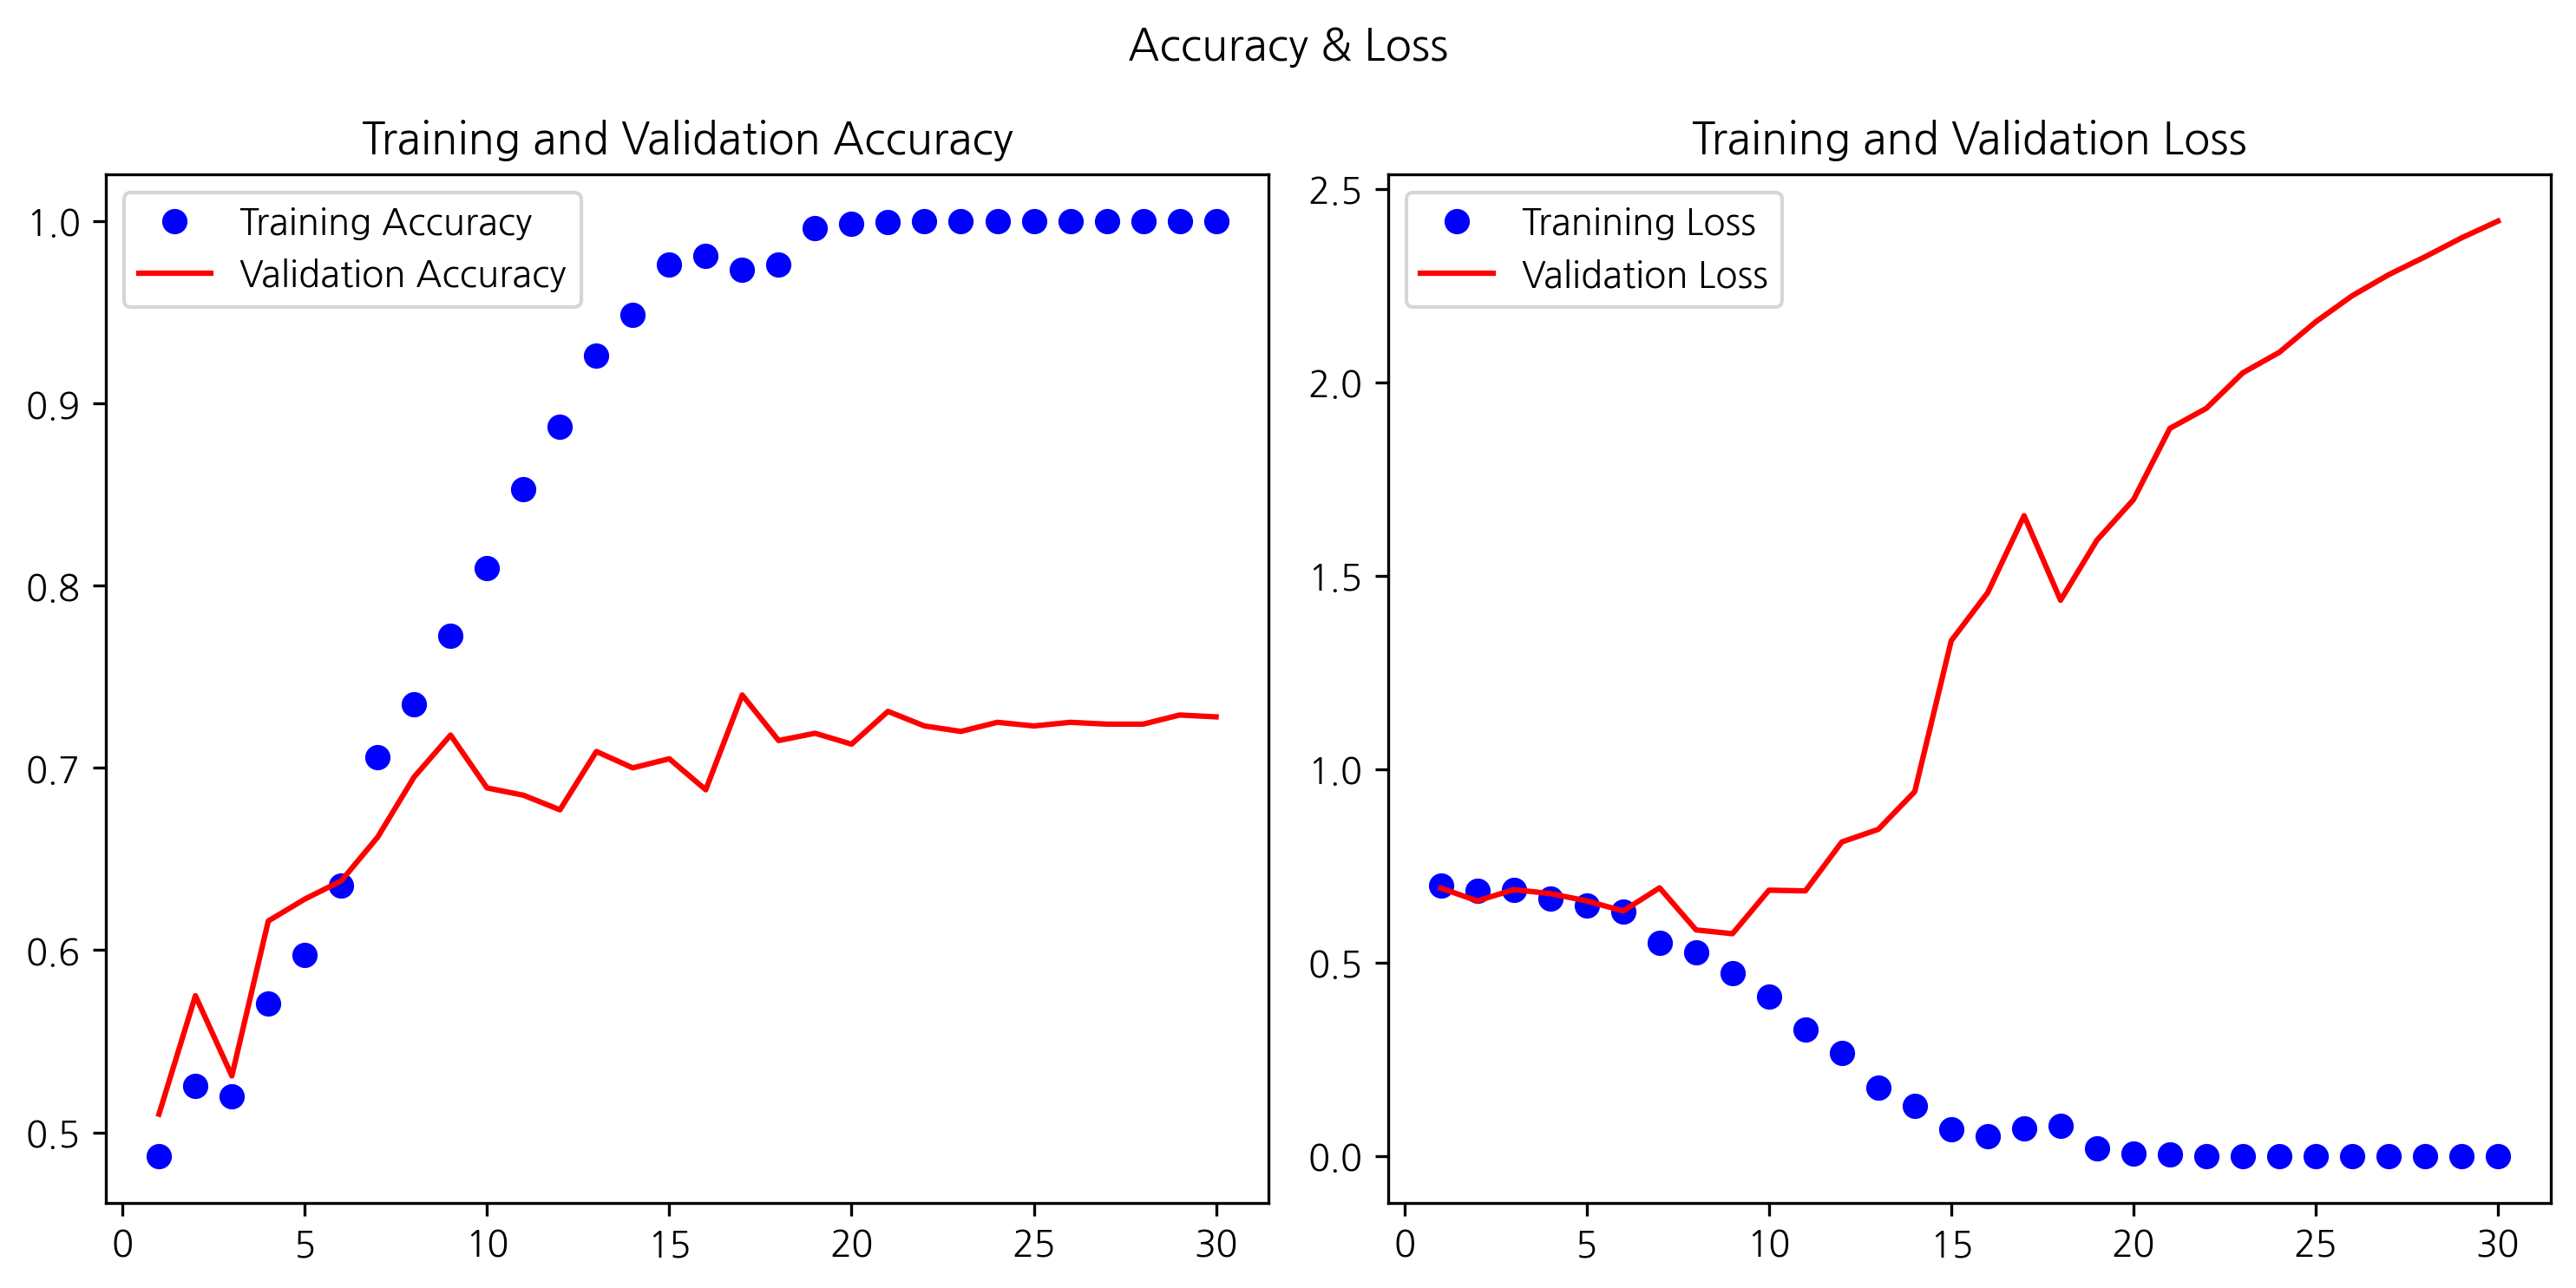

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend() 

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo', label='Tranining Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.suptitle('Accuracy & Loss')
plt.tight_layout()

plt.show() 

# 과대적합 억제하는 가장 좋은 방법 = 훈련 데이터 수를 늘리는 거다. 
# 데이터 증식을 통해 과대적합 억제해보자. 

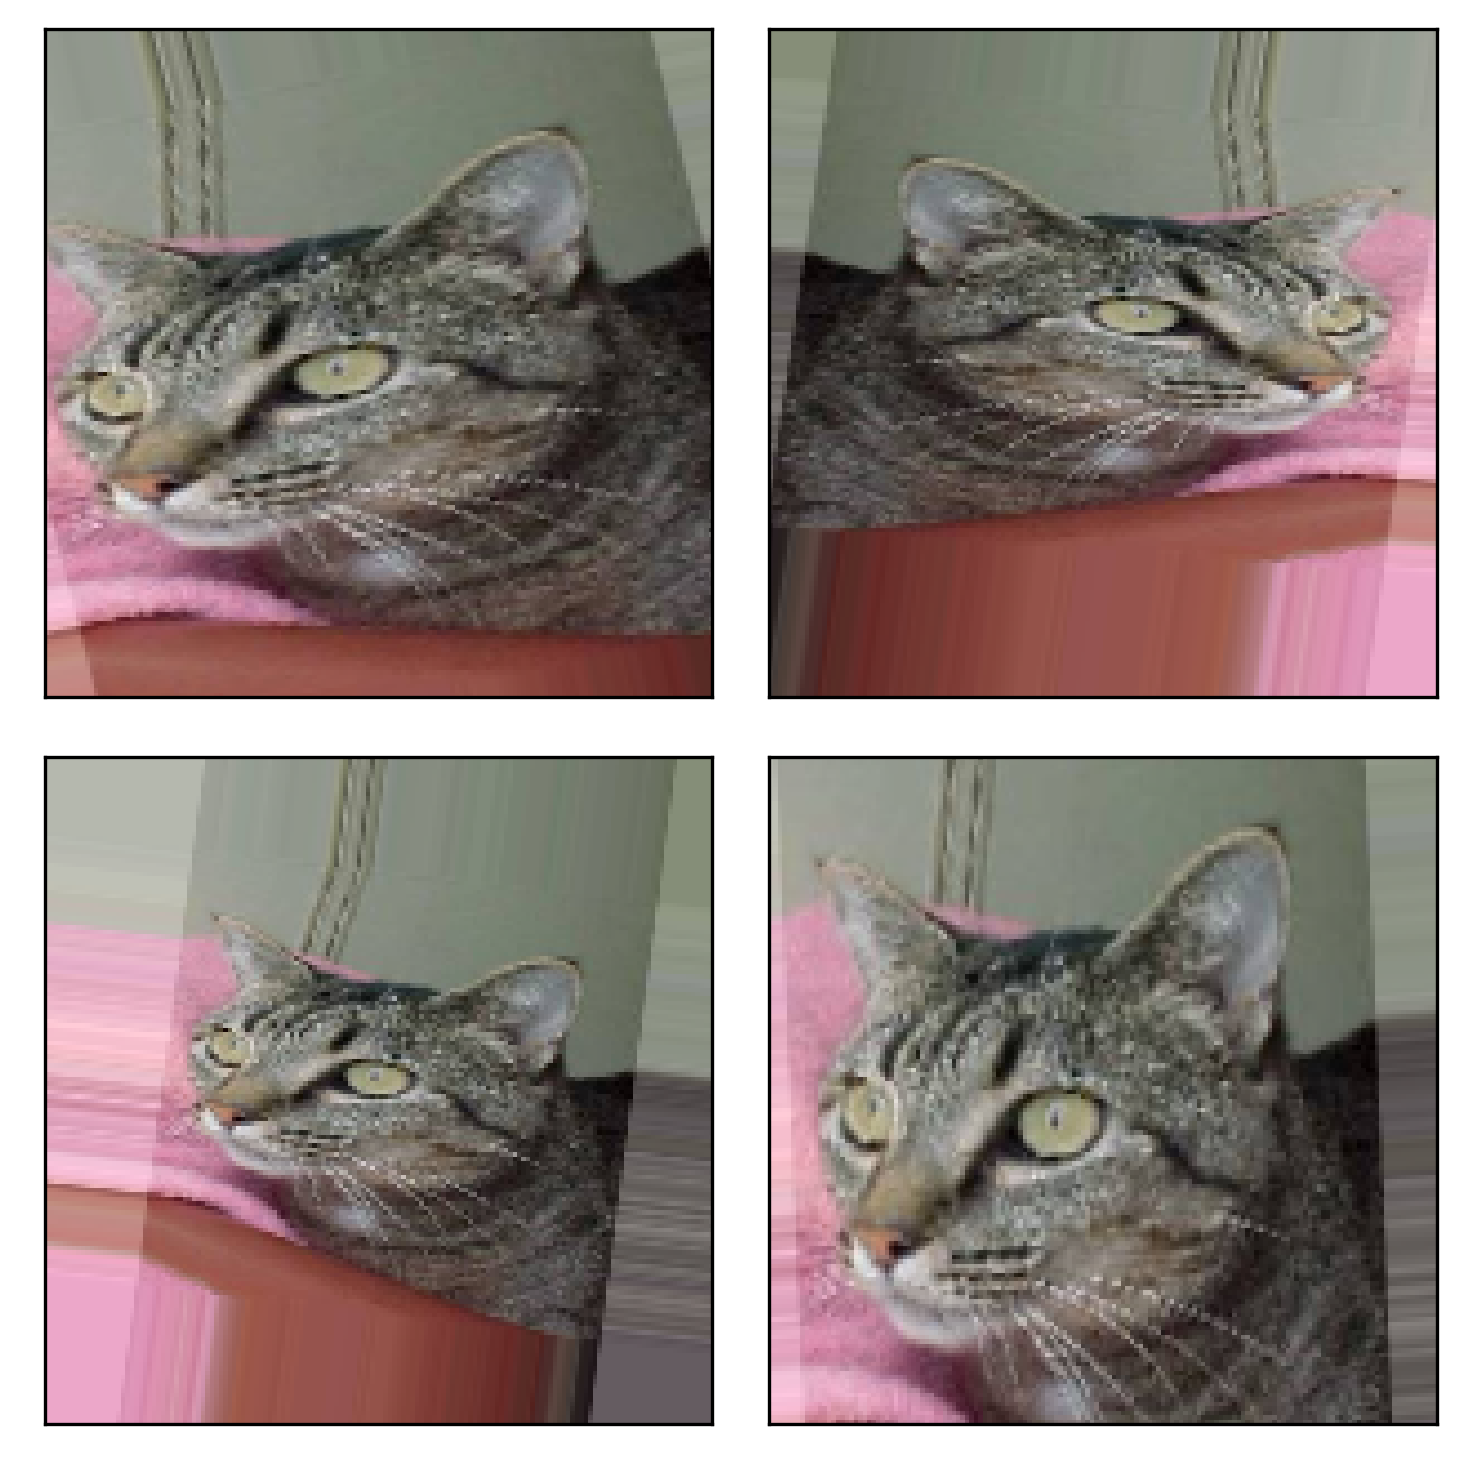

In [53]:
# 데이터 증식 

datagen = ImageDataGenerator(
    rotation_range=30, # 회전을 몇 도 시킬 건가 
    width_shift_range=0.1, # 수평으로 평행이동 정도 
    height_shift_range=0.1, # 수직으로 평행이동 정도 
    shear_range=0.2,  # y축 방향으로 각도 증가 
    zoom_range=0.5,  # 확대/축소 범위
    horizontal_flip=True, # 좌우 대칭시킨다
    fill_mode='nearest' 
)

# 데이터 증식 결과 시각화해서 살펴보기 
from keras.preprocessing import image 

fnames = sorted([os.path.join('/Users/kibeomkim/Desktop/cats_and_dogs_small/train/cats', fname) for fname in os.listdir('/Users/kibeomkim/Desktop/cats_and_dogs_small/train/cats')])
img_path = fnames[7]

img = image.load_img(img_path, target_size = (150,150))  # 이미지 읽어오기, 크기 150*150으로 변환 

x = image.img_to_array(img) # (150,150,3) 크기 넘파이 배열(텐서)로 변환 
x = x.reshape((1,)+x.shape) # (1,150,150,3) 으로 변환 (배치 차원 추가)

plt.figure(figsize=(5,5))
i = 1
for batch in datagen.flow(x, batch_size=1) : 
    plt.subplot(2,2,i) # i번째 이미지 
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    plt.xticks([])
    plt.yticks([])
    i += 1 
    if i == 5 : break 
plt.tight_layout()
plt.show()

In [62]:
# 드롭아웃 포함한 새로운 컨브넷 정의 

from keras import models 
from keras import layers 
from keras import optimizers

model = models.Sequential() 
# 합성곱 기반 층
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2))) 
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))

# 완전 연결 분류기 
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# 모델 컴파일 
model.compile(
    loss = 'binary_crossentropy', 
    metrics = ['acc'], 
    optimizer = optimizers.adam_v2.Adam(lr = 0.001)
)

# 데이터 증식 & 전처리 

train_datagen = ImageDataGenerator(
    rescale = 1./255, 
    rotation_range = 40, 
    width_shift_range= 0.1, 
    height_shift_range=0.1, 
    shear_range = 0.4, 
    zoom_range= 0.5, 
    horizontal_flip=True 
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    '/Users/kibeomkim/Desktop/cats_and_dogs_small/train', 
    target_size=(150,150), 
    batch_size= 20, 
    class_mode='binary'
)

valid_generator = test_datagen.flow_from_directory(
    '/Users/kibeomkim/Desktop/cats_and_dogs_small/test', 
    target_size = (150,150), 
    batch_size=20, 
    class_mode = 'binary'
)

# 모델 훈련 
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=100, 
    epochs = 100,
    validation_data = valid_generator, 
    validation_steps = 50 
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100


2022-02-26 20:00:28.350410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 0.7047 - acc: 0.5140

2022-02-26 20:00:37.417075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 11s 103ms/step - loss: 0.7047 - acc: 0.5140 - val_loss: 0.6919 - val_acc: 0.5000
Epoch 2/100
100/100 [==============================] - 10s 100ms/step - loss: 0.6931 - acc: 0.5225 - val_loss: 0.6887 - val_acc: 0.5790
Epoch 3/100
100/100 [==============================] - 10s 101ms/step - loss: 0.6912 - acc: 0.5390 - val_loss: 0.6989 - val_acc: 0.5000
Epoch 4/100
100/100 [==============================] - 10s 102ms/step - loss: 0.6926 - acc: 0.5055 - val_loss: 0.6913 - val_acc: 0.5010
Epoch 5/100
100/100 [==============================] - 10s 101ms/step - loss: 0.6917 - acc: 0.5305 - val_loss: 0.6921 - val_acc: 0.5200
Epoch 6/100
100/100 [==============================] - 10s 102ms/step - loss: 0.6920 - acc: 0.5065 - val_loss: 0.6771 - val_acc: 0.5940
Epoch 7/100
100/100 [==============================] - 10s 102ms/step - loss: 0.6892 - acc: 0.5620 - val_loss: 0.6797 - val_acc: 0.5920
Epoch 8/100
100/100 [==============================] - 10s 1

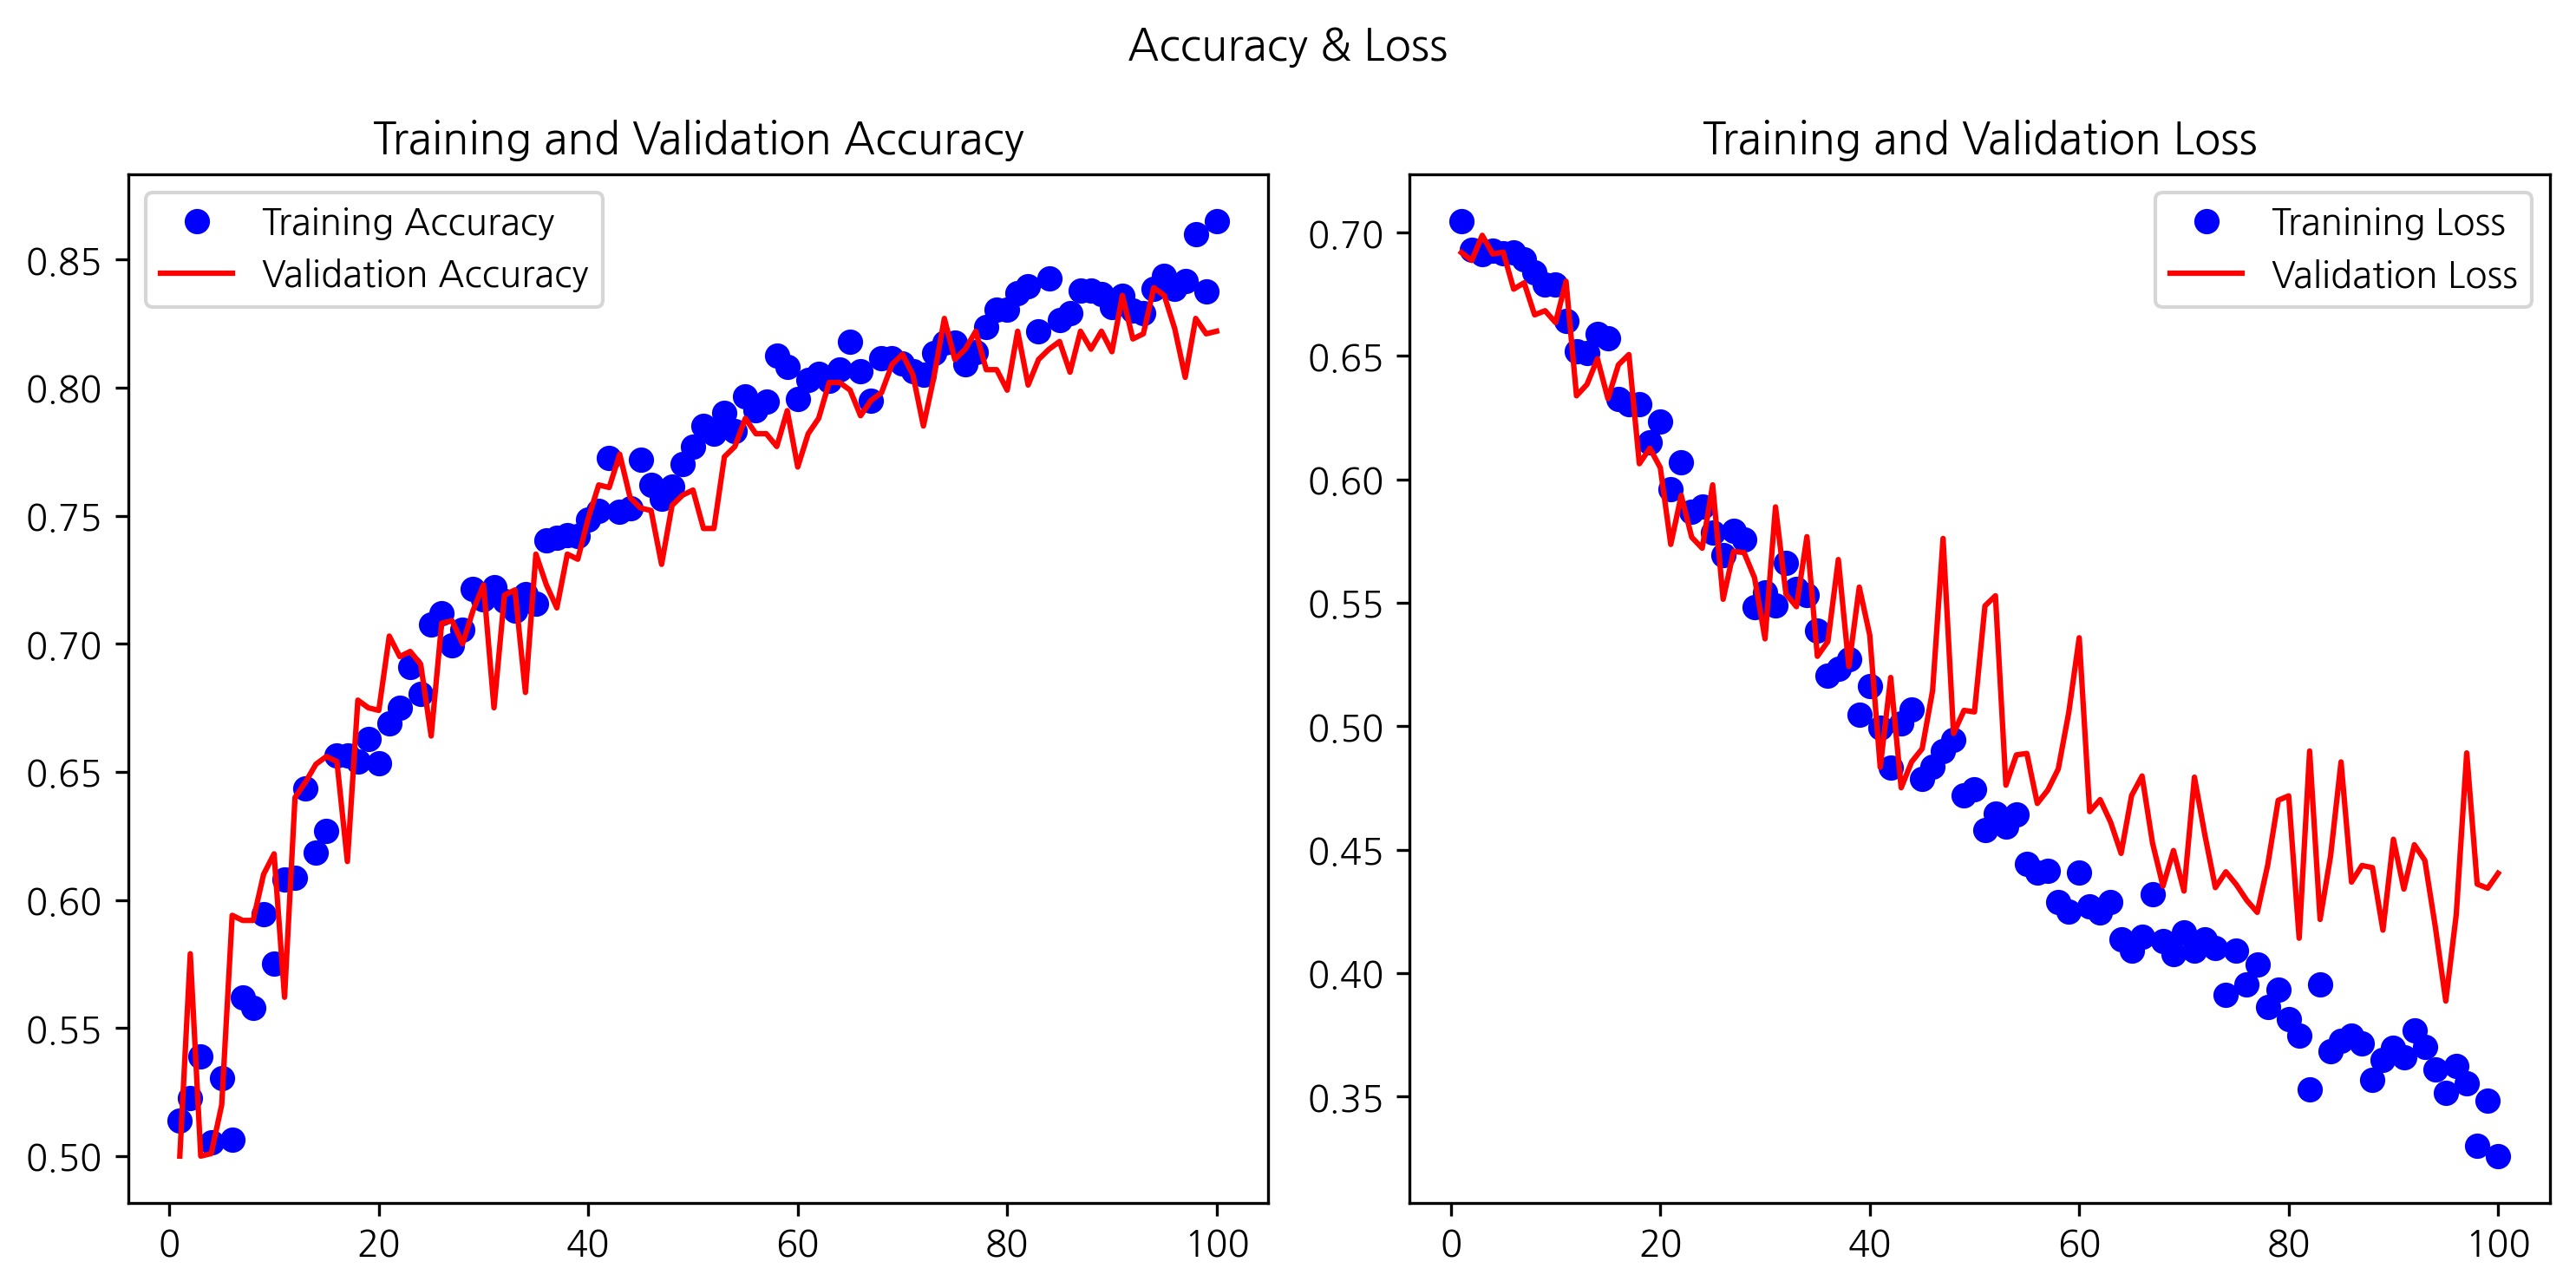

In [63]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend() 

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo', label='Tranining Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.suptitle('Accuracy & Loss')
plt.tight_layout()

plt.show() 

# 컨브넷 학습 시각화 

In [66]:
model.save('/Users/kibeomkim/Desktop/models_saved/dog_and_cant.h5')

In [96]:
from keras.models import load_model 

# 저장한 작은 컨브넷 로드 
model2 = load_model('/Users/kibeomkim/Desktop/models_saved/dog_and_cant.h5')
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 17, 17, 128)     

In [119]:
# 합성곱 층, 풀링 층 출력 시각화 
# '활성화' 시각화 
img_path = '/Users/kibeomkim/Desktop/cc.png'

from keras.preprocessing import image 

img = image.load_img(img_path, target_size=(150,150))
img_tensor = image.img_to_array(img) # 텐서로 변환 
img_tensor = np.expand_dims(img_tensor, axis=0) # 배치 축 추가 

img_tensor /= 255.  # 1/255로 스케일 조정 

print(img_tensor.shape)

(1, 150, 150, 3)


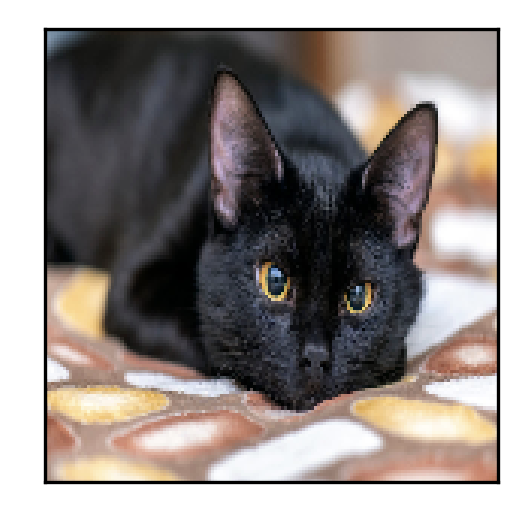

In [120]:
# 원본 이미지 출력 
plt.figure(figsize=(2,2))
plt.imshow(img_tensor[0])
plt.xticks([])
plt.yticks([])
plt.show()

In [121]:
# 상위 8개 레이어 출력만 추출 
from keras import models 

layer_outputs = [layer.output for layer in model2.layers[:8]] # 상위 8개 레이어 출력 추출 

# 특정 입력에 대한 출력 매핑하는 모형 
activation_model = models.Model(inputs=model2.input, outputs=layer_outputs)
# 하나 입력에 대해: 8개 출력 대응된다 (층 8개 출력 결과)

# 예측모드로 모델 실행하기 
activations = activation_model.predict(img_tensor) # img_tensor 1개 입력에 대해: 8개 층 각각에 통과시켜서 그 출력 반환 

2022-02-26 21:54:51.149974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


(1, 148, 148, 32)


<Figure size 600x600 with 0 Axes>

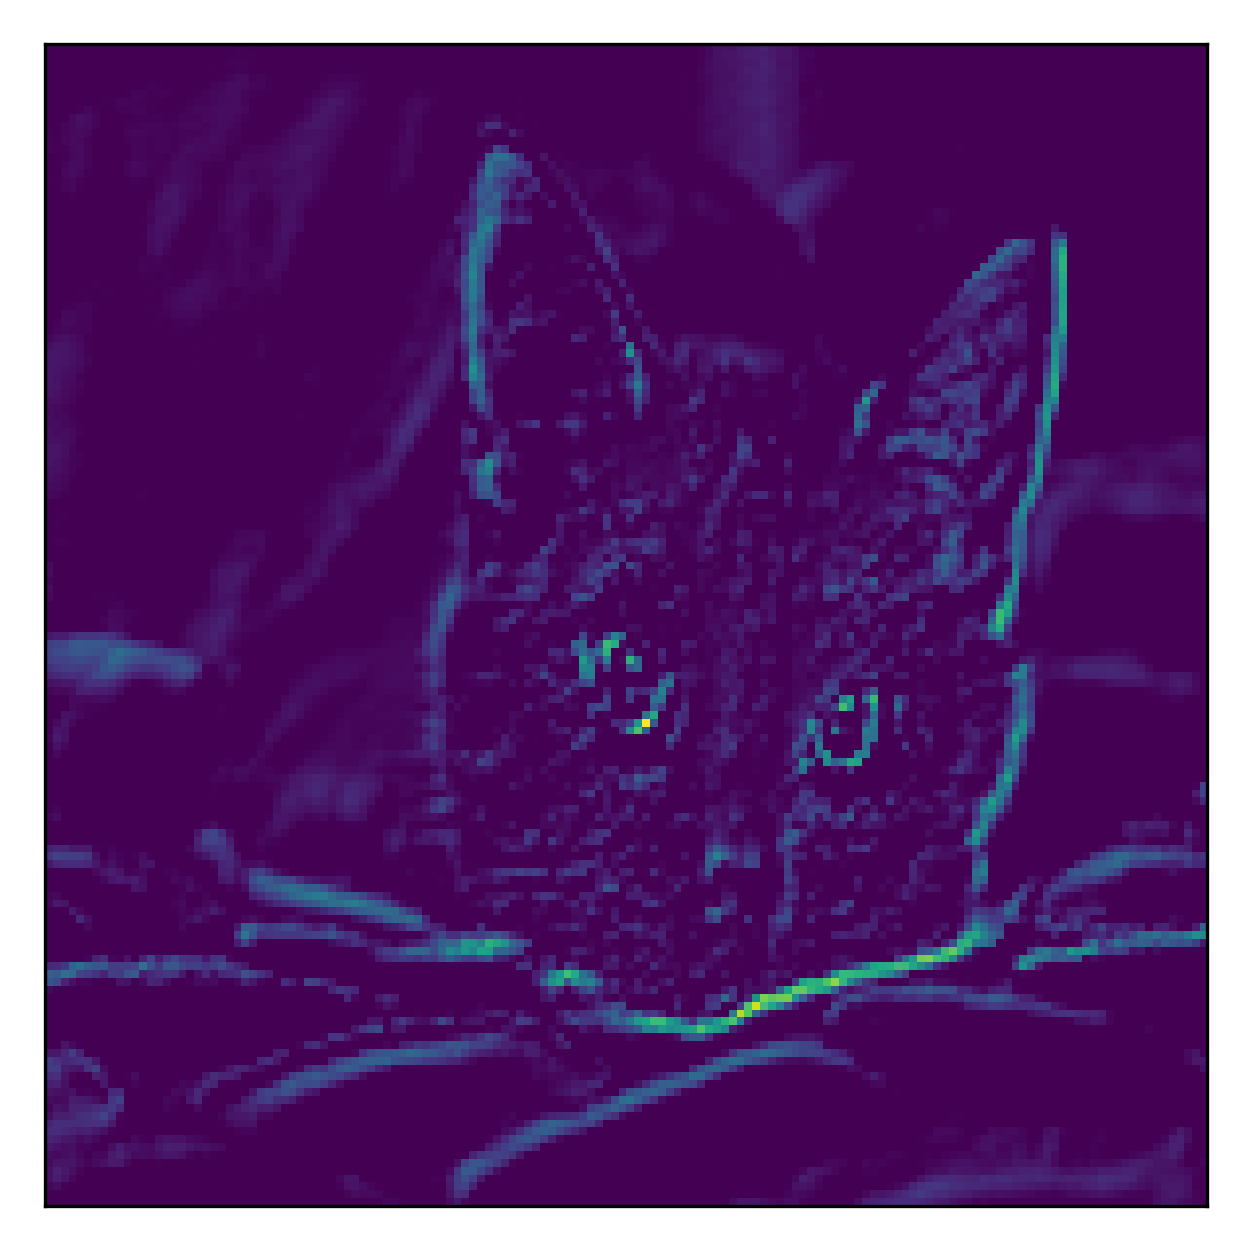

In [125]:
# 첫번째 합성곱 층 활성화 맵 시각화 
first_layer_activation_result = activations[0]
print(first_layer_activation_result.shape) # 합성곱 결과: 높이 148, 너비 148, 배치 1, 필터 적용한 응답 맵 32개 

# 응답 맵 32개 중 12번째 응답 맵 시각화 
plt.figure(figsize=(2,2))
plt.matshow(first_layer_activation_result[0, :,:,21], cmap='viridis')
plt.xticks([])
plt.yticks([])
plt.show()

# 이 필터는 고양이 얼굴 윤곽을 감지하는 것 같다. 

(1, 148, 148, 32)


<Figure size 600x600 with 0 Axes>

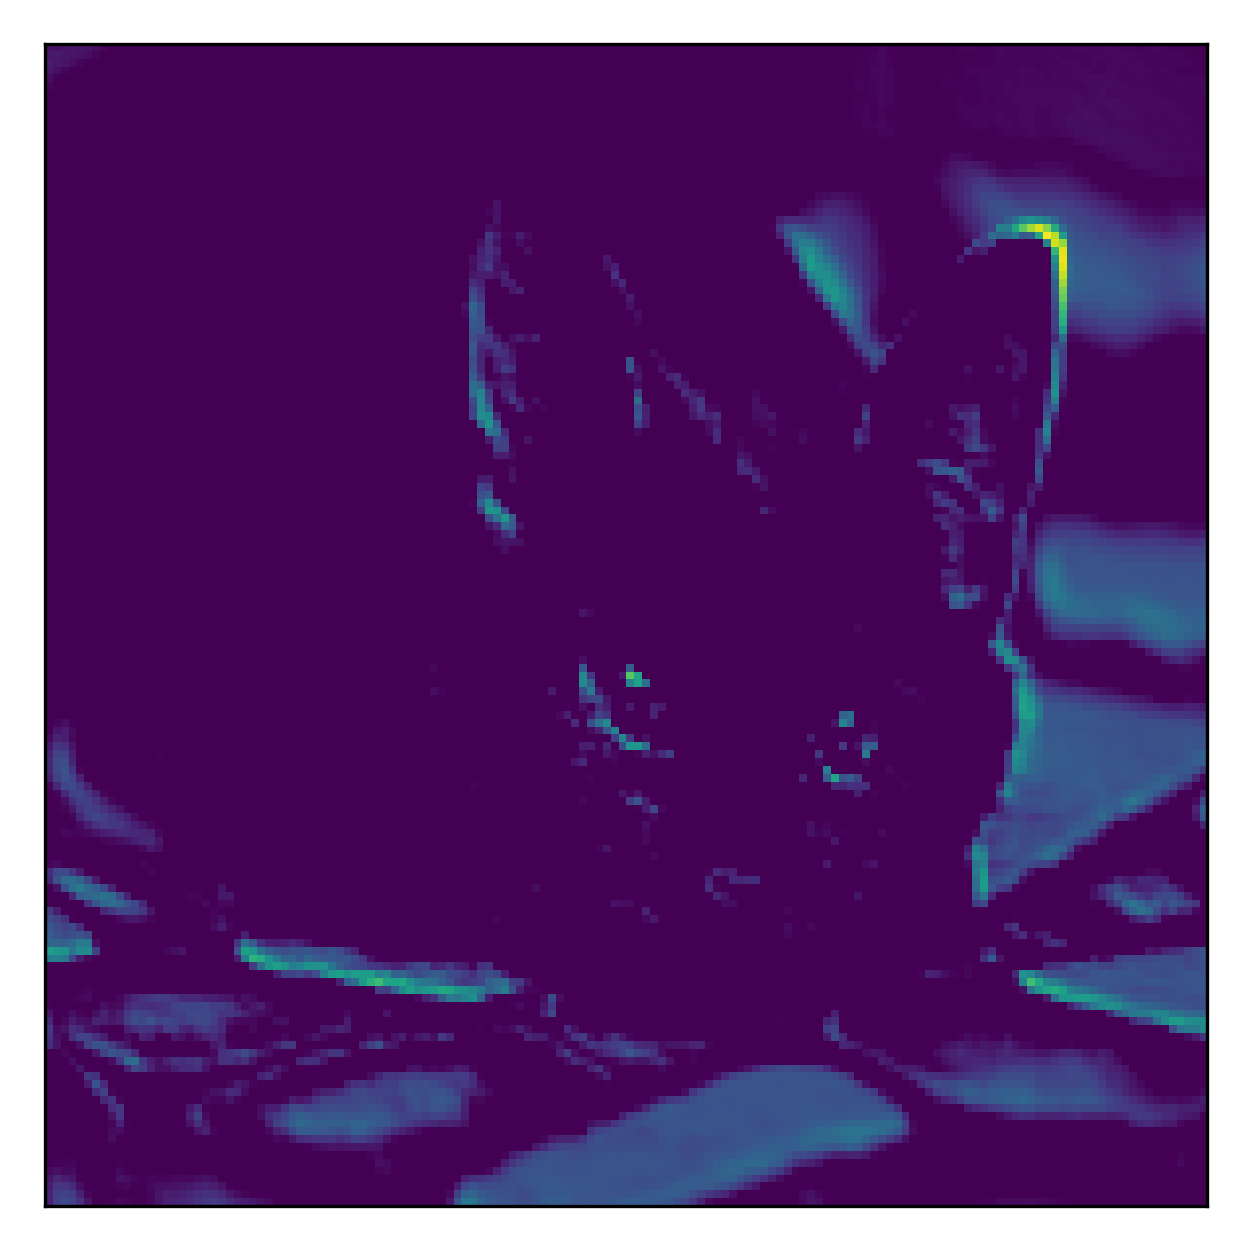

In [129]:
# 첫번째 합성곱 층 활성화 맵 시각화 
first_layer_activation_result = activations[0]
print(first_layer_activation_result.shape) # 합성곱 결과: 높이 148, 너비 148, 배치 1, 필터 적용한 응답 맵 32개 

# 응답 맵 32개 중 12번째 응답 맵 시각화 
plt.figure(figsize=(2,2))
plt.matshow(first_layer_activation_result[0, :,:,2], cmap='viridis')
plt.xticks([])
plt.yticks([])
plt.show()

In [133]:
# 네트워크 모든 활성화 시각화 
layer_names = []
for layer in model2.layers[:8] : # 상위 8개 층 이름들 추출 (그림 이름으로 사용)
    layer_names.append(layer.name)
print(layer_names)

['conv2d_13', 'max_pooling2d_11', 'conv2d_14', 'max_pooling2d_12', 'conv2d_15', 'max_pooling2d_13', 'conv2d_16', 'max_pooling2d_14']


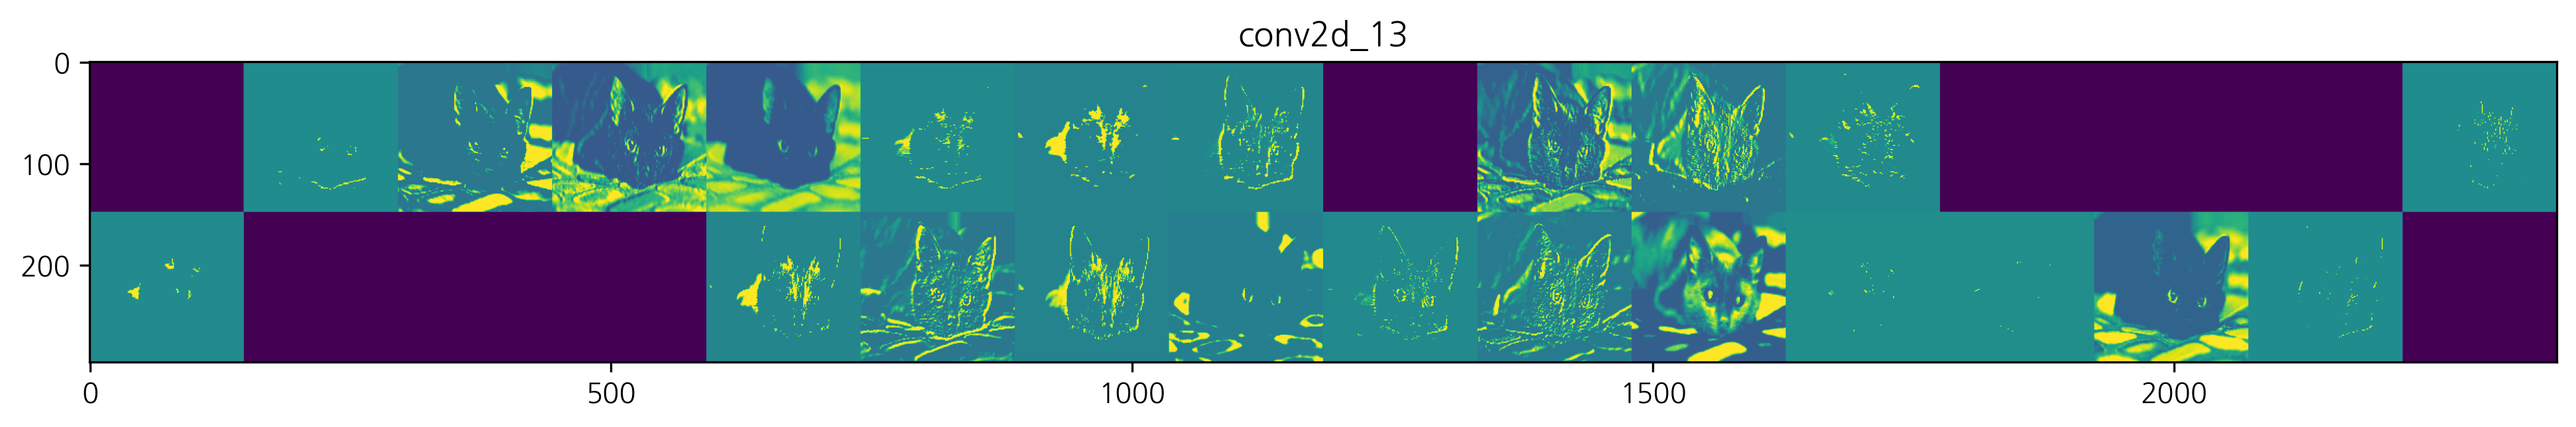

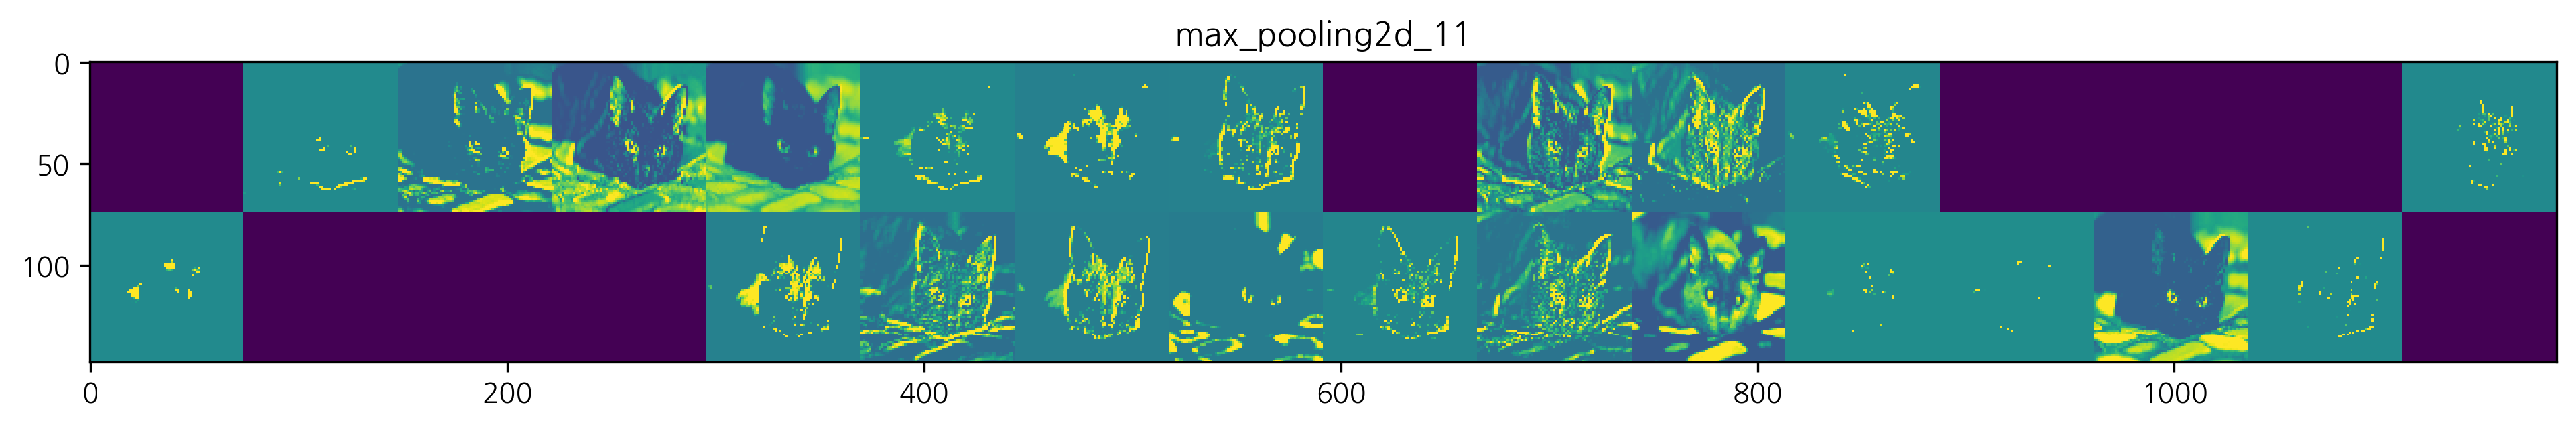

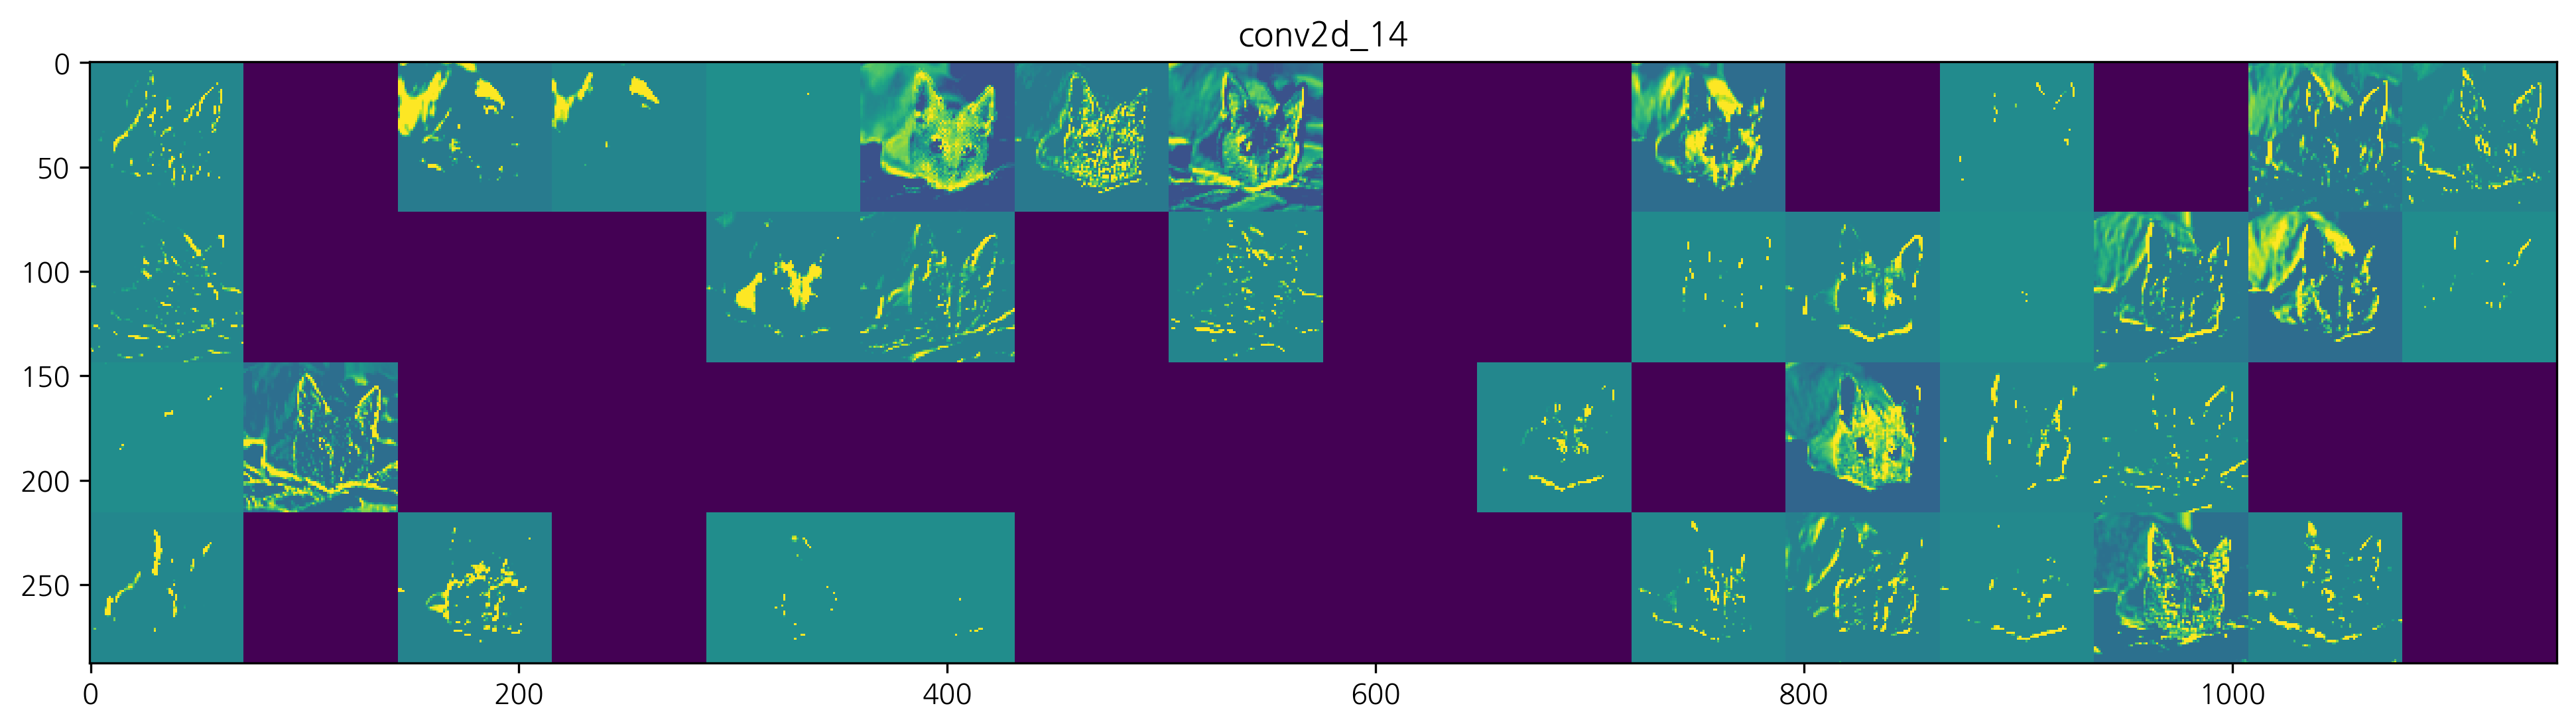

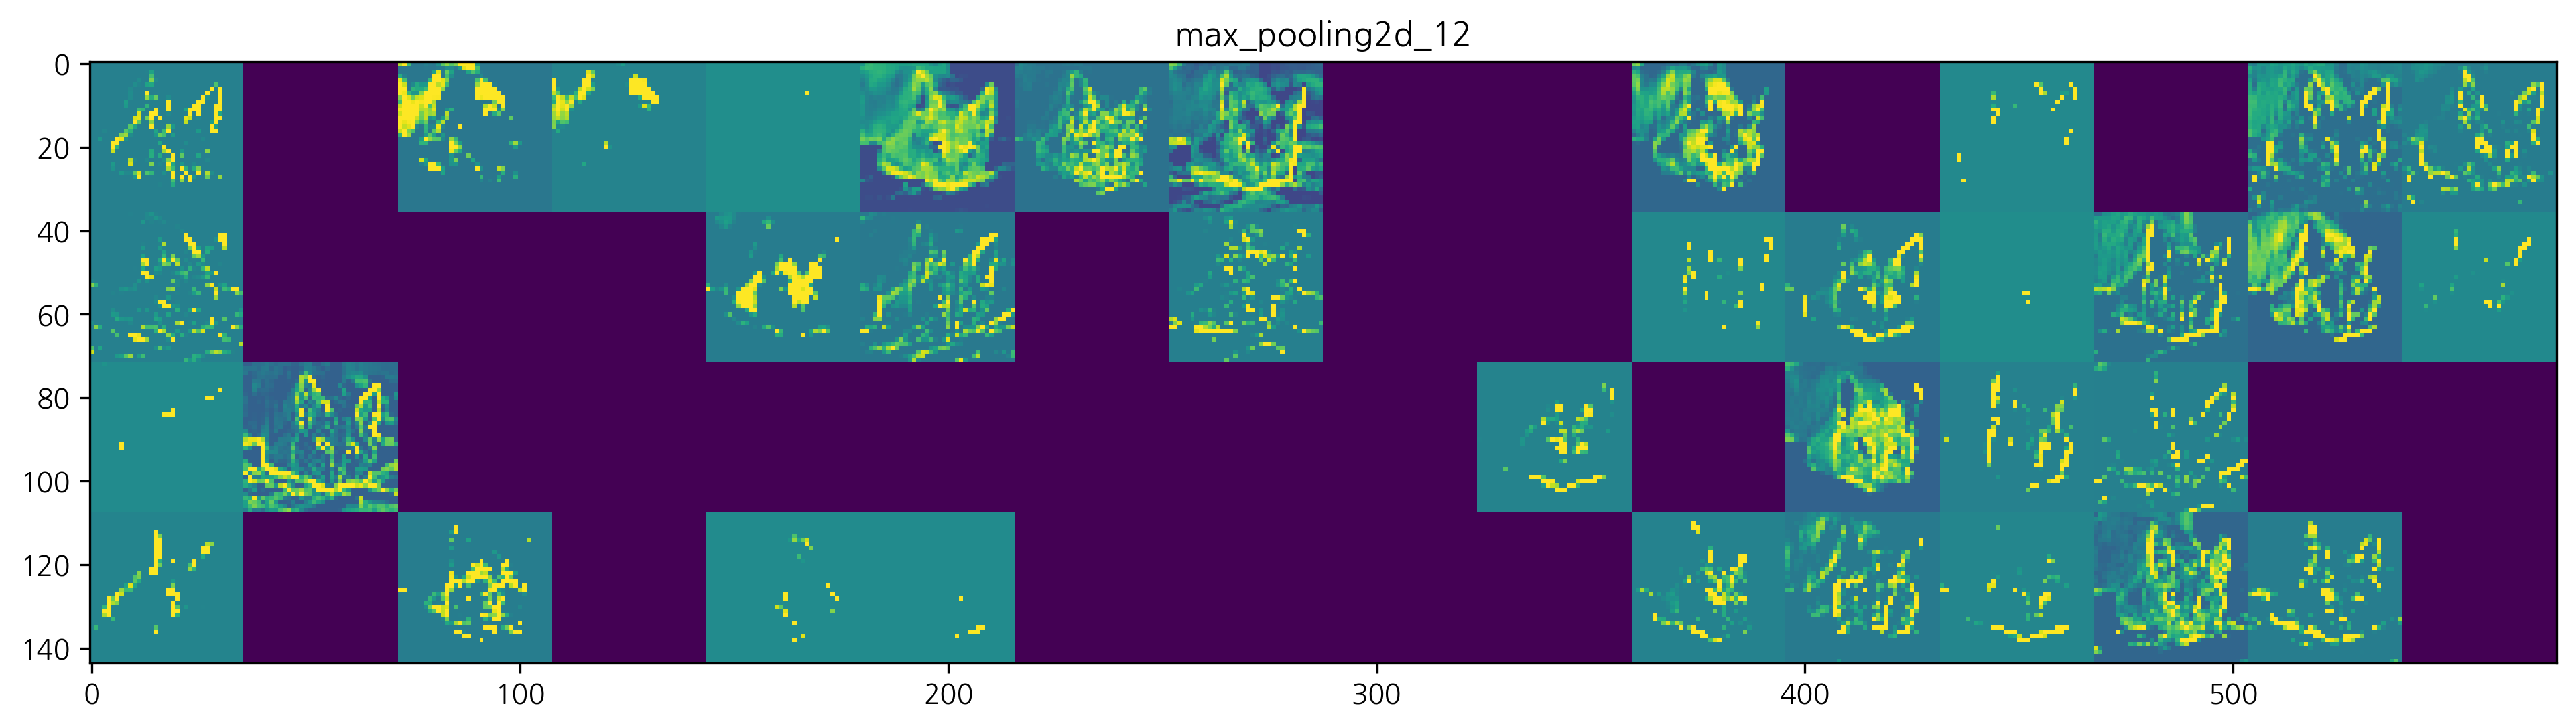

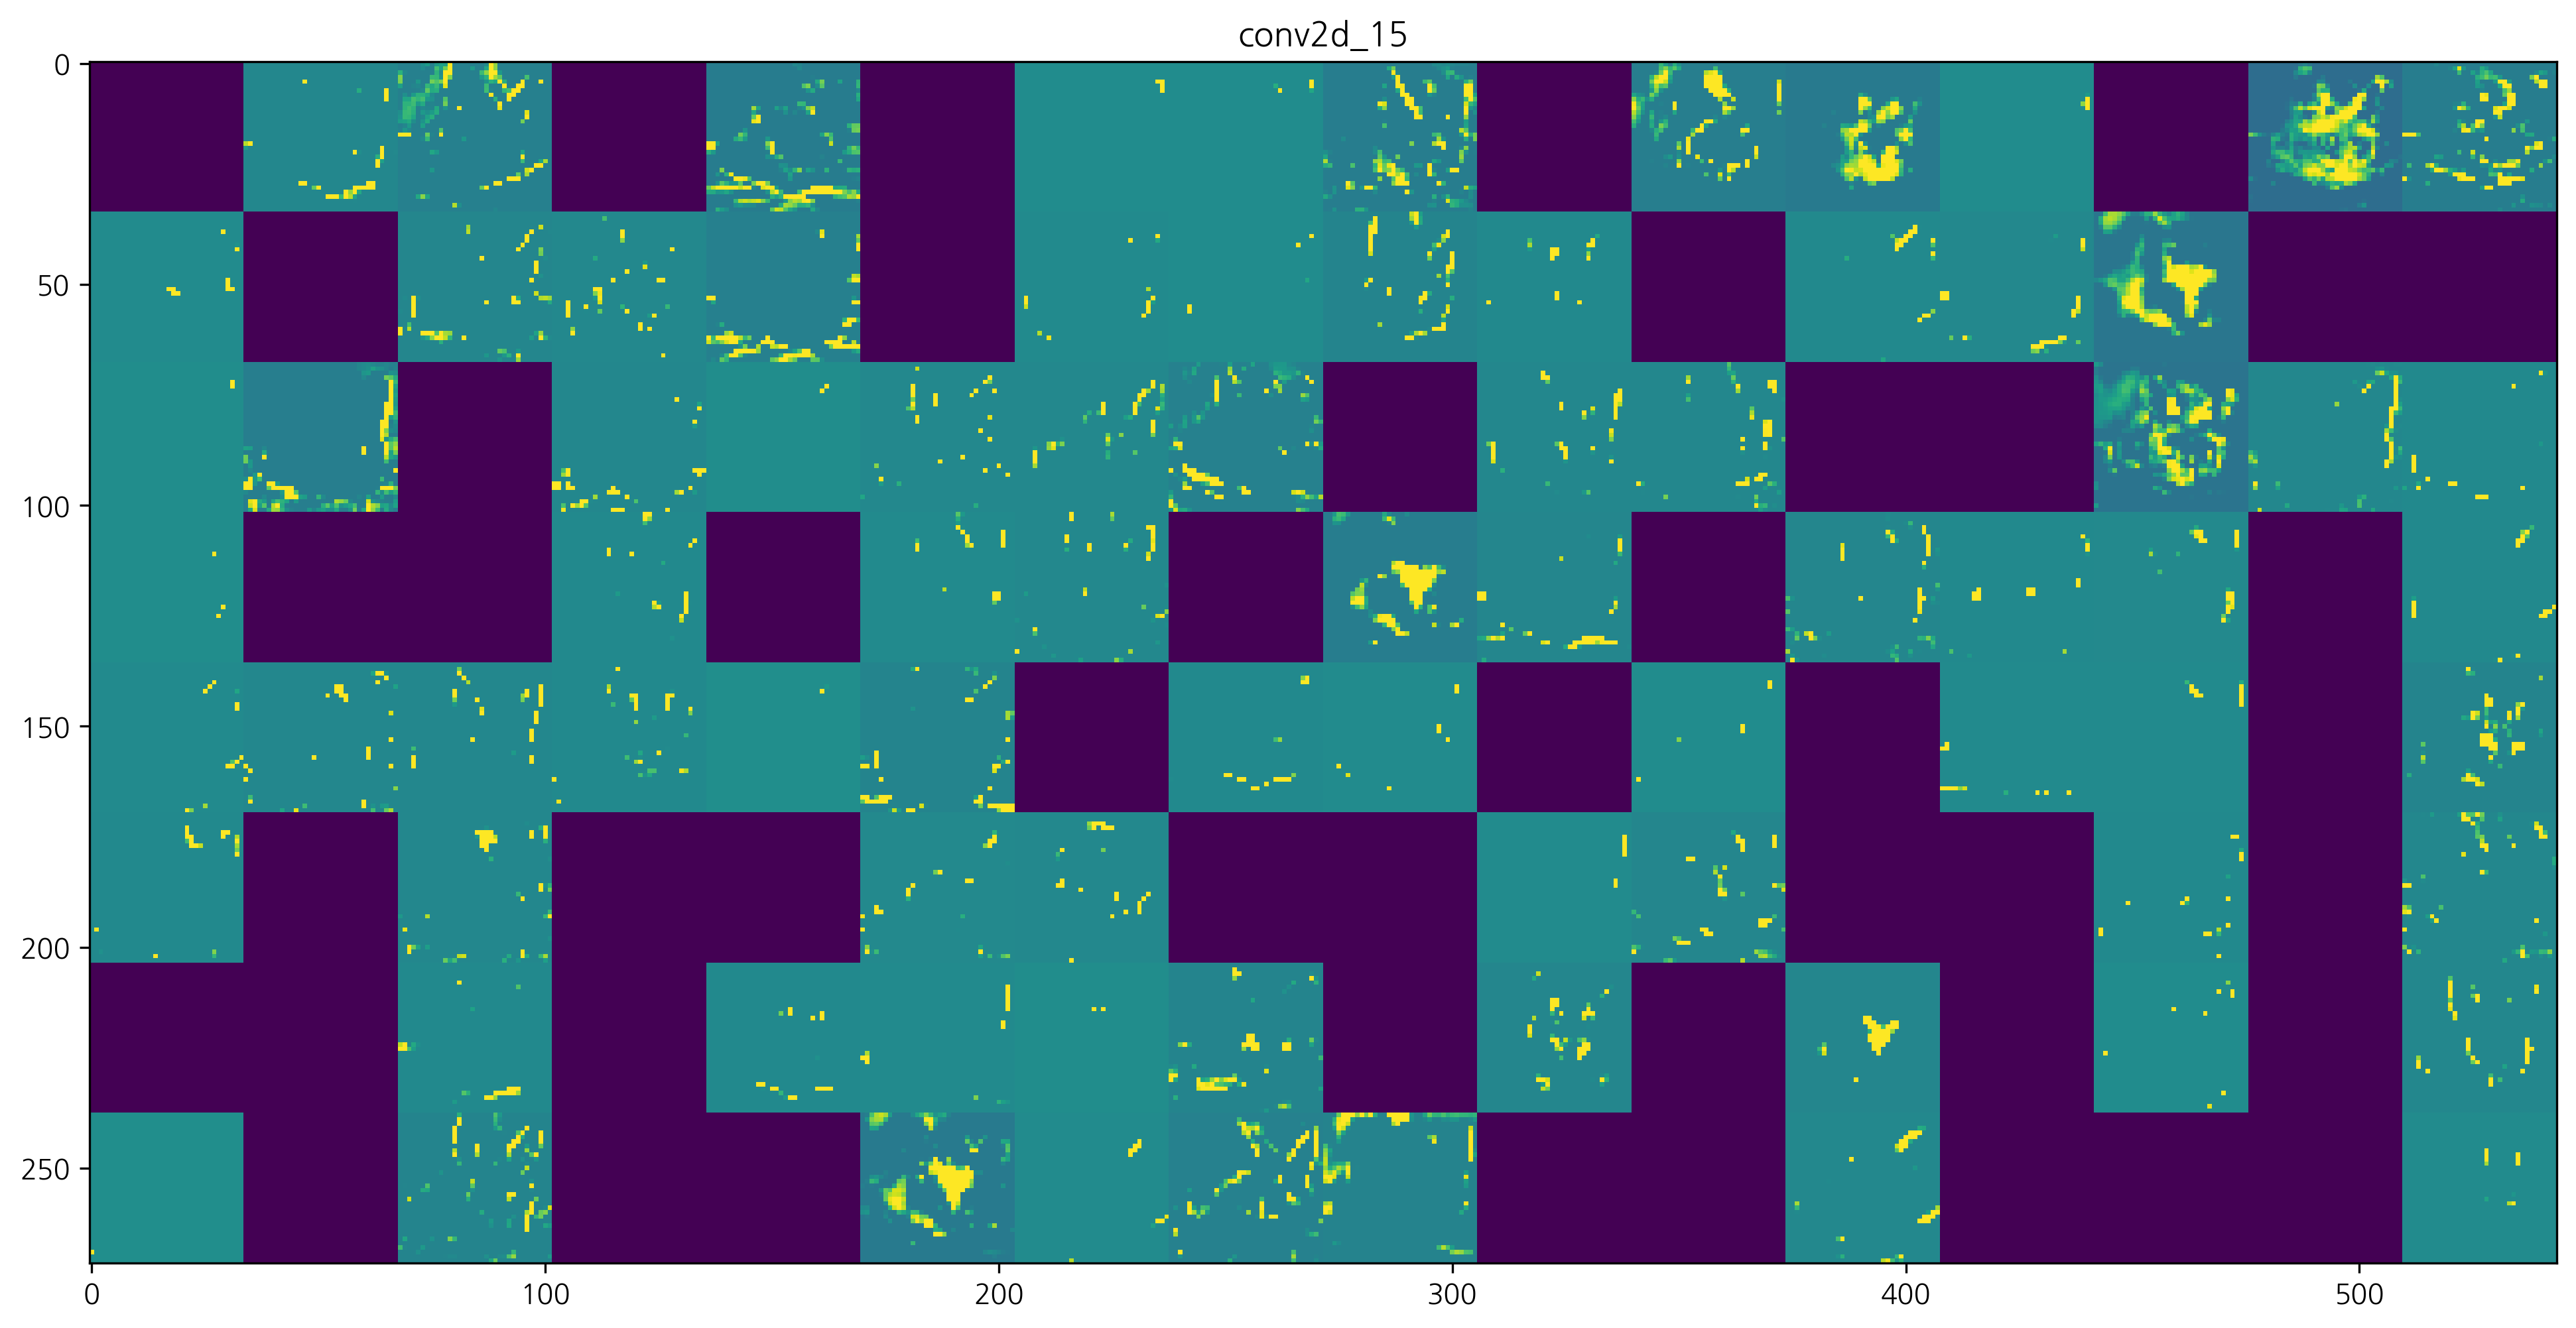

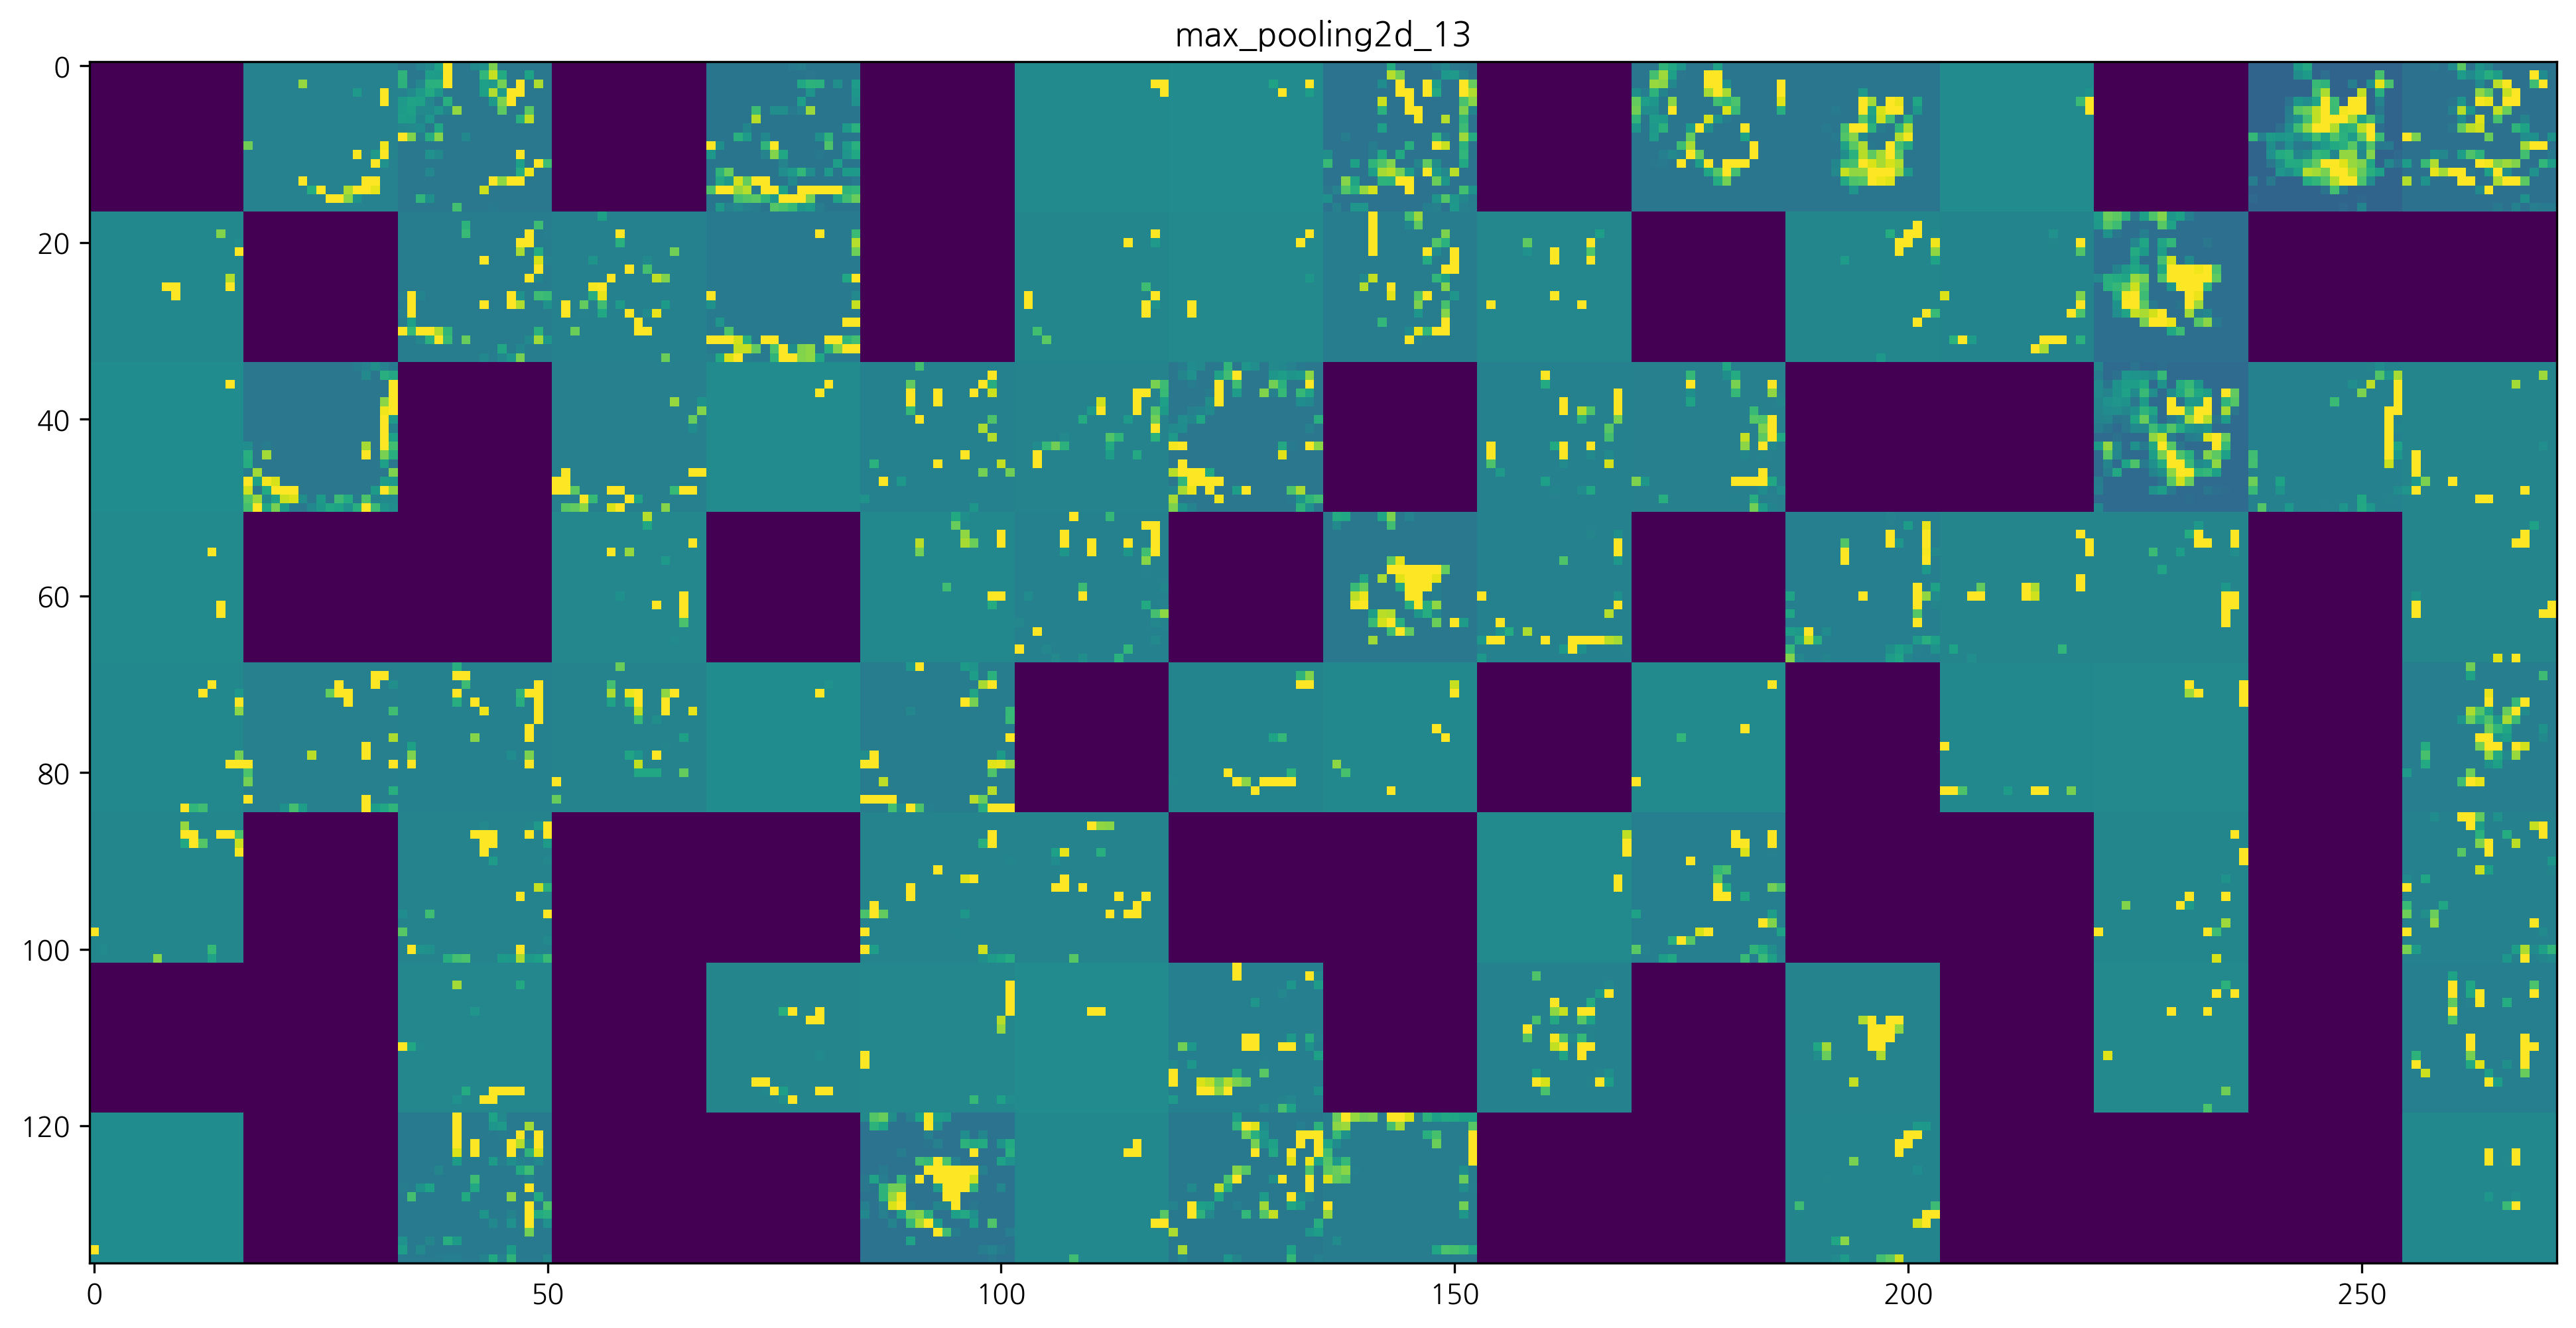

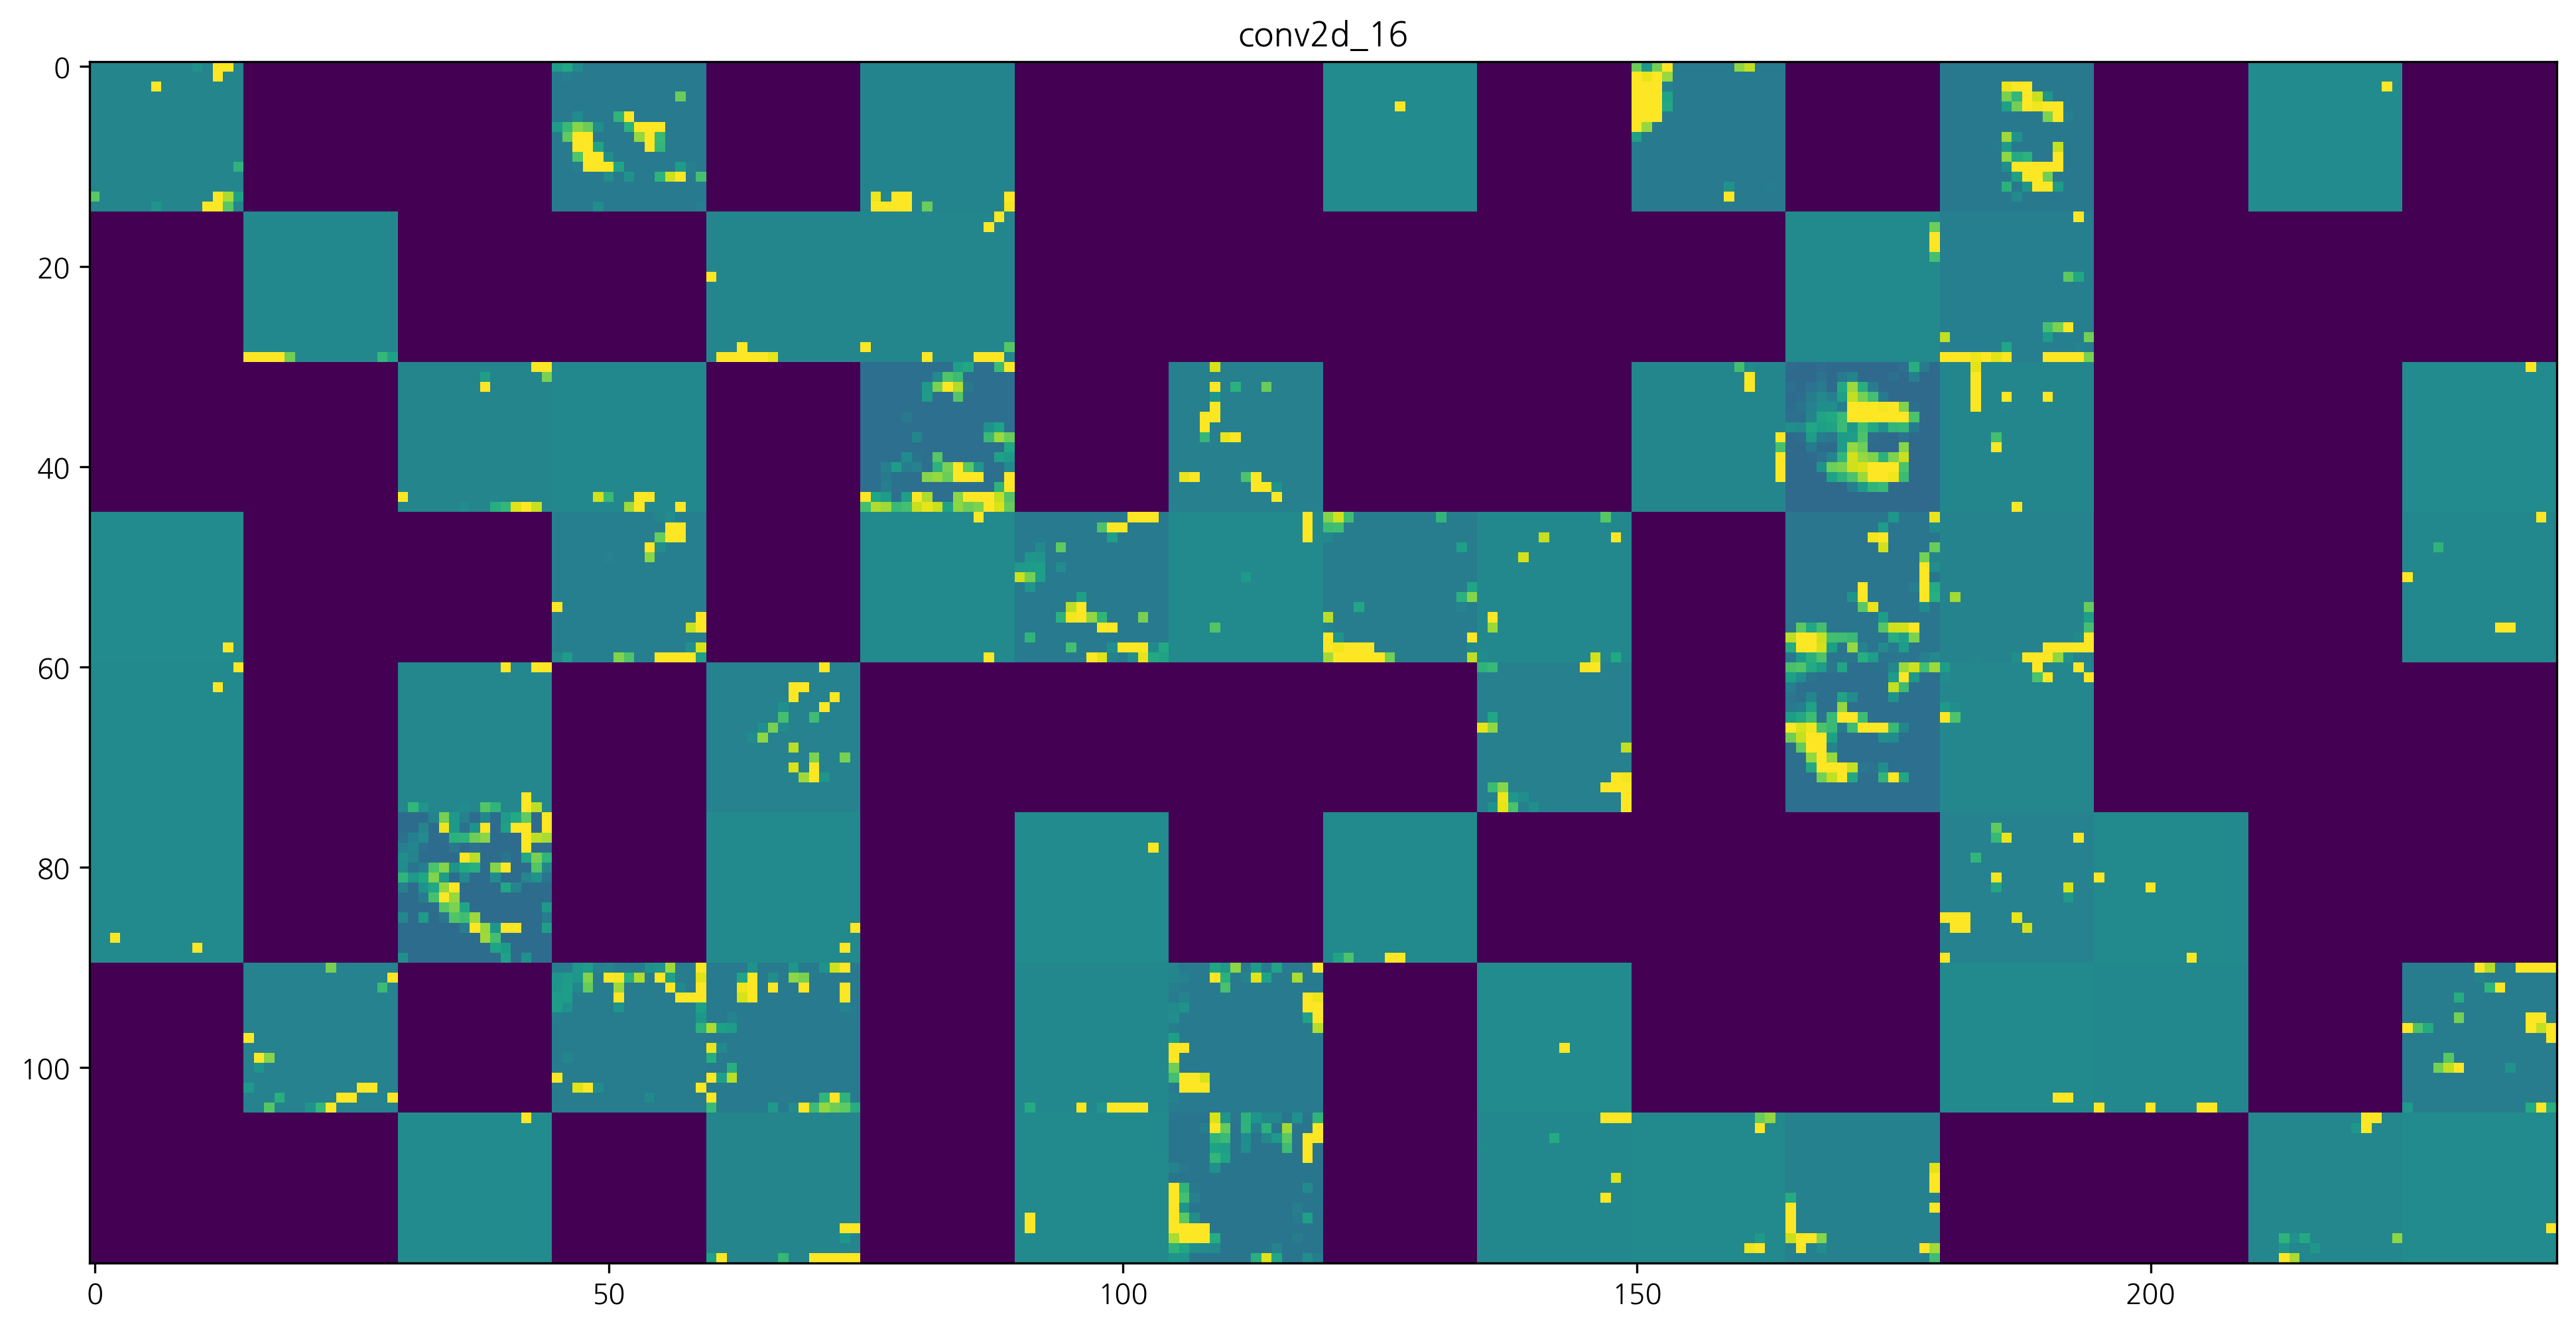

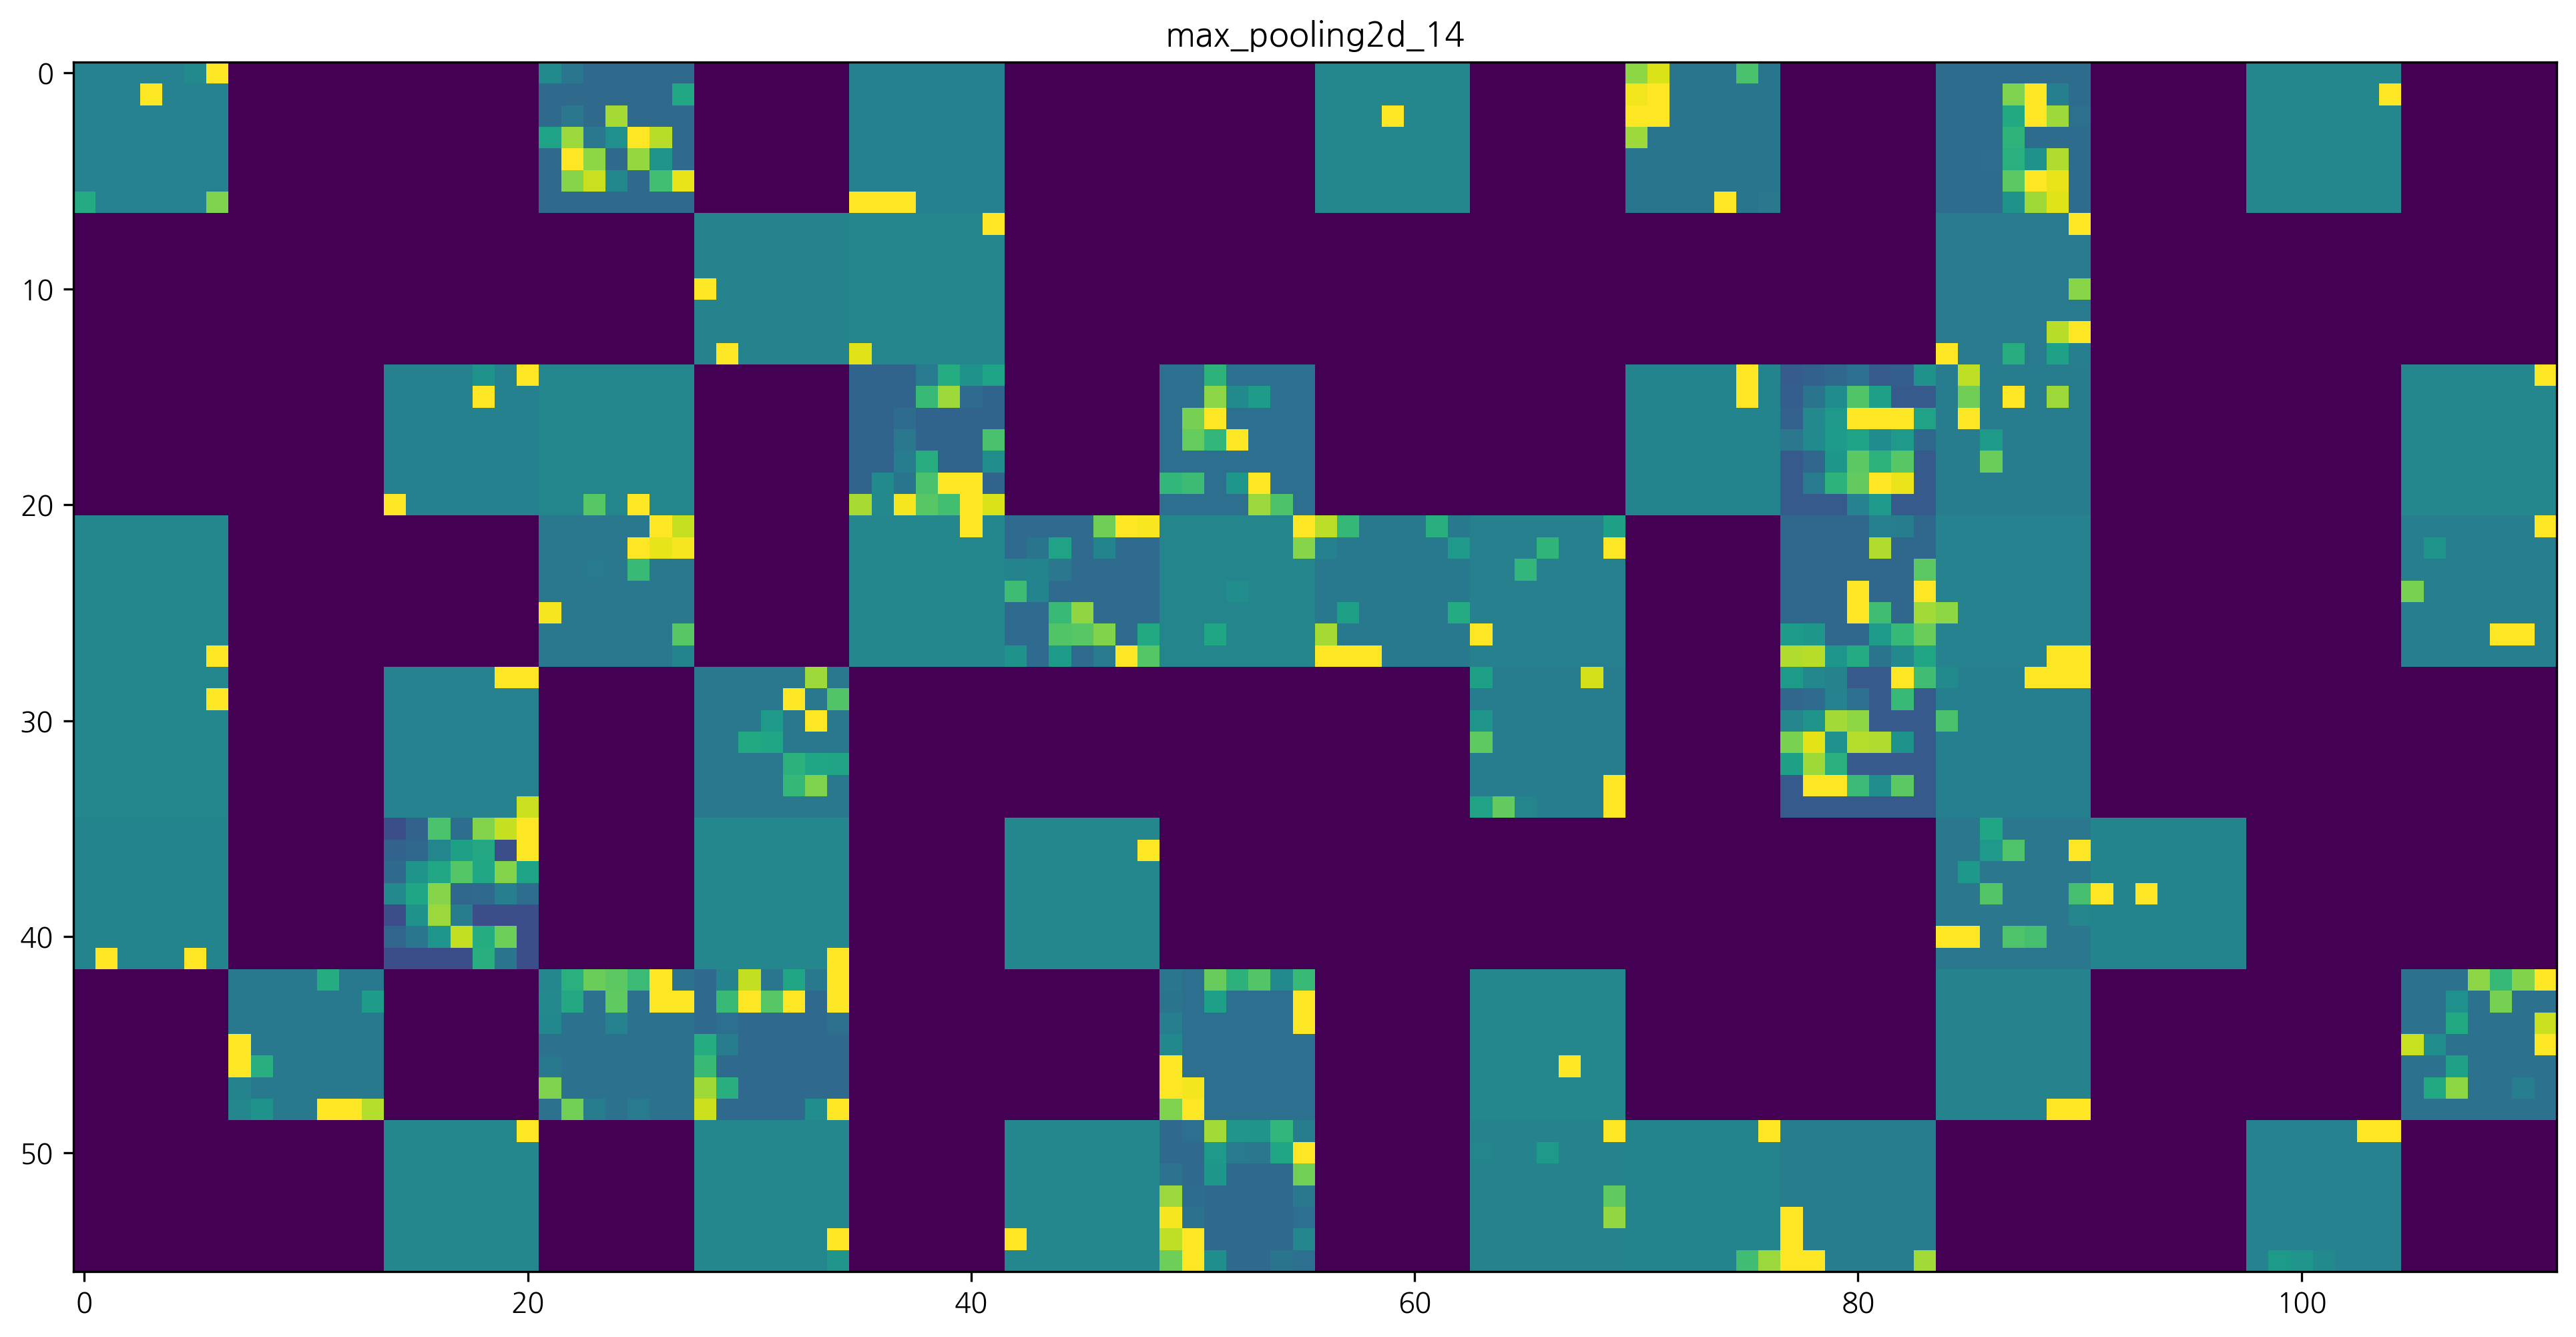

In [147]:
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations) : # 층 - 활성화 매핑 
    n_features = layer_activation.shape[-1] # 활성화 마다 채널 수 

    size = layer_activation.shape[1] # 높이와 너비 어차피 같다. 

    n_cols = n_features // images_per_row 
    display_grid = np.zeros((size*n_cols, images_per_row*size))

    for col in range(n_cols) : 
        for row in range(images_per_row) : 
            channel_image = layer_activation[0, :, :, col*images_per_row+row]
            # 채널 이미지 스케일 조정 
            # 정규화 
            channel_image -= channel_image.mean() 
            channel_image /= channel_image.std() 
            
            channel_image*=64 
            channel_image += 128 
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col*size : (col+1)*size, row*size:(row+1)*size] = channel_image

    scale = 1./size 
    plt.figure(figsize=(scale*display_grid.shape[1], scale*display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    #plt.xticks([])
    #plt.yticks([])
plt.show()

# 상위층으로 갈 수록, 모델이 학습한 '고양이의 특징'들만 남게된다. 
# 위 마지막 이미지가 듬성듬성 빈 건, 입력 이미지가 모델이 학습한 고양이 특징들 중 일부를 안 갖고 있었다는 말이다. (필터에 응답 발생하지 않았다.)
# 뇌가 현실세계의 객체를 인식하는 방식과 매우 유사한 학습법이다. 

# 클래스 활성화 맵: 입력 이미지 어느 부분이 모델이 그렇게 분류하는 데 크게 기여했는지 시각화 

In [224]:
from keras.applications.vgg16 import VGG16 

model = VGG16(weights='imagenet')

2022-02-27 22:42:35.507999: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-27 22:42:35.514085: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-02-27 22:42:35.639959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-27 22:42:35.779608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-27 22:42:38.498352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [261]:
from keras.preprocessing import image 
from keras.applications.vgg16 import preprocess_input, decode_predictions 
import os 

img_path = '/Users/kibeomkim/Desktop/in.png'

img = image.load_img(img_path, target_size=(224,224))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0) # 배치차원 추가 
x.shape

x = preprocess_input(x) # 정규화 

In [262]:
preds = model.predict(x)
len(preds[0]) # 이미지넷 1000개 클래스 각각으로 분류 될 확률

# 예측결과: 상위 3개 
print('예측결과 상위 3개:', end='')
print(decode_predictions(preds, top=3)[0])

print(np.argmax(preds)) # 벡터 원소 중 최댓값 반환 

# 클래스 활성화 맵 시각화 
output = model.output[:, 386]

last_conv_layer = model.get_layer('block5_conv3')

import keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

grads = K.gradients(output,last_conv_layer.output)[0]

예측결과 상위 3개:[('n01871265', 'tusker', 0.54870605), ('n02504013', 'Indian_elephant', 0.37231407), ('n02504458', 'African_elephant', 0.07897882)]
101


In [263]:
pooled_grads = K.mean(grads, axis=(0,1,2))
iterate = K.function(
    [model.input], 
    [pooled_grads, last_conv_layer.output[0]]
)

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512) : 
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)

2022-02-27 22:57:11.356994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


(-0.5, 13.5, 13.5, -0.5)

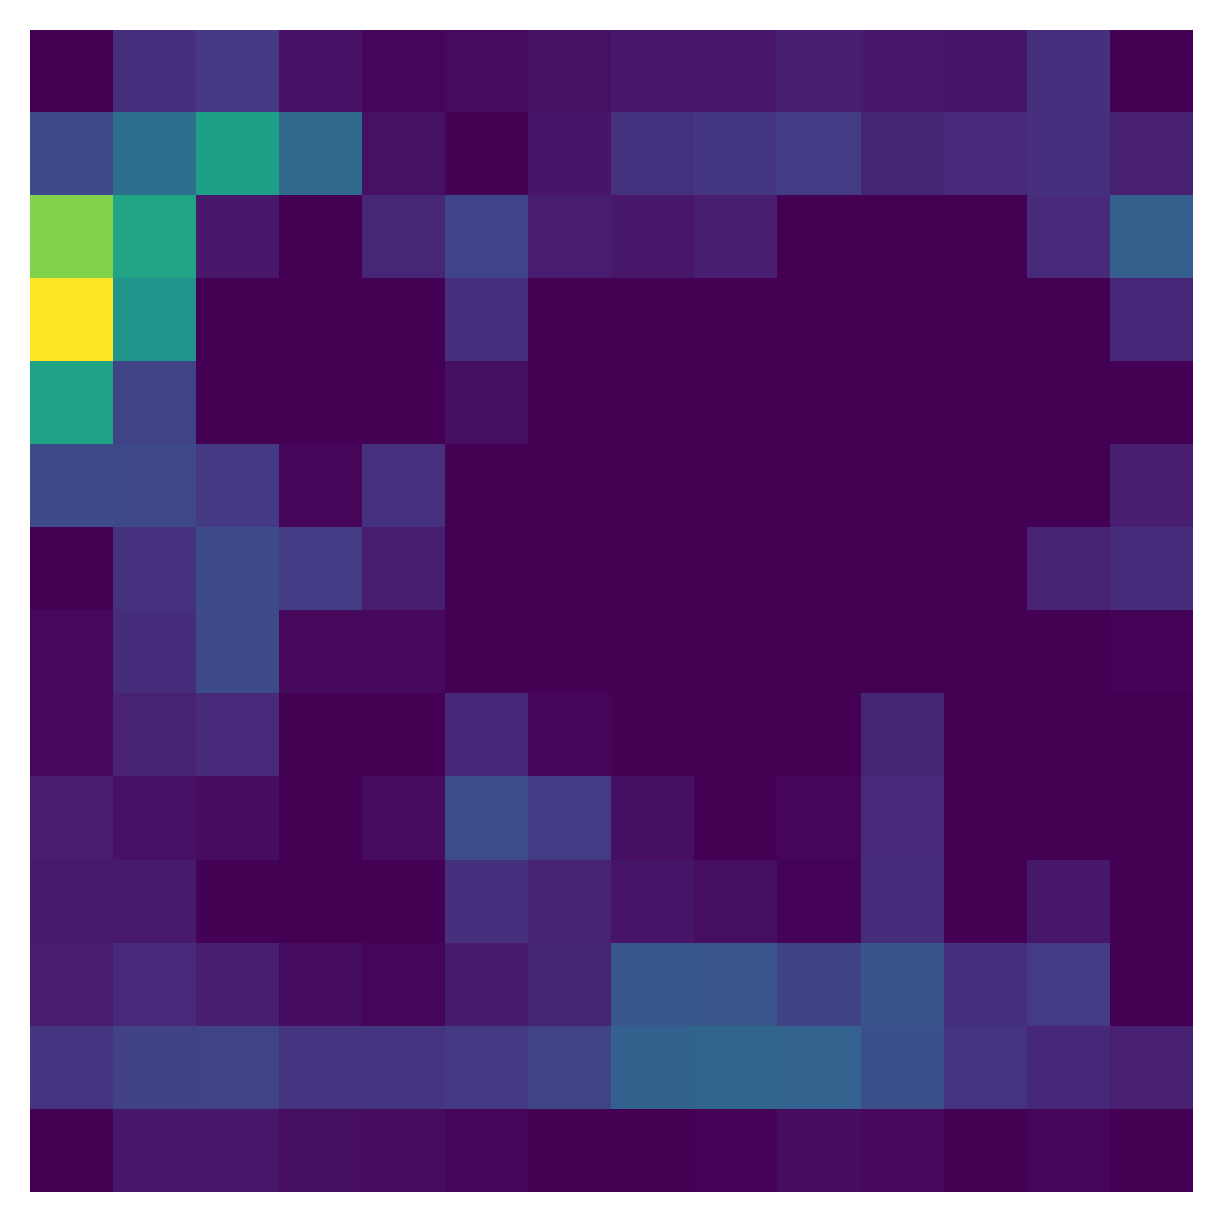

In [264]:
# 히트맵 정규화 
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.axis(False)

In [265]:
import cv2 

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255*heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap*0.4 + img 
cv2.imwrite('/Users/kibeomkim/Desktop/heatmap_integrated.jpg', superimposed_img)

True